In [11]:
# %matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pylab as plt
import sys
import glob, os

curr_ld_lib_path = ''
os.environ['LD_LIBRARY_PATH'] = curr_ld_lib_path + ':/project/projectdirs/openmsi/jupyterhub_libs/boost_1_55_0/lib' + ':/project/projectdirs/openmsi/jupyterhub_libs/lib'
import sys
# sys.path.remove('/anaconda/lib/python2.7/site-packages')
sys.path.append('/global/project/projectdirs/openmsi/jupyterhub_libs/anaconda/lib/python2.7/site-packages')
sys.path.insert(0,'/project/projectdirs/openmsi/projects/meta-iq/pactolus/pactolus' )

from generate_frag_dag import *

import score_frag_dag

sys.path.insert(0,'/global/project/projectdirs/metatlas/anaconda/lib/python2.7/site-packages' )

from metatlas import metatlas_objects as metob
from metatlas import h5_query as h5q
from metatlas import mzml_to_hdf

import h5py
import tables
import pickle

from rdkit import Chem
# from rdkit.Chem.rdMolDescriptors import ExactMolWt
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

from copy import deepcopy


from pyteomics import mgf

from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG,display

In [73]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
#     mol = Chem.MolFromSmiles(smiles)
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = AllChem.ReplaceSubstructs(mol, reactant, product)
            rms_smiles = Chem.MolToSmiles(rms[0])
            mol = Chem.MolFromSmiles(rms_smiles)
    if replaced:
        return (mol, True) #Chem.MolToSmiles(mol,True)
    else:
        return (mol, False)
def drawStructure_ShowingFragment(pactolus_tree,fragment_idx,myMol,myMol_w_Hs):

    drawer = rdMolDraw2D.MolDraw2DSVG(600,300)

    fragment_atoms = np.where(pactolus_tree[fragment_idx]['atom_bool_arr'])[0]
    mark_atoms_no_H = []
    for a_index in fragment_atoms:
        if myMol_w_Hs.GetAtomWithIdx(a_index).GetSymbol() != 'H':
            mark_atoms_no_H.append(a_index)

    rdDepictor.Compute2DCoords(myMol)

    drawer.DrawMolecule(myMol,highlightAtoms=mark_atoms_no_H)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace('svg:','')
    return svg

def drawStructure_Fragment(pactolus_tree,fragment_idx,myMol,myMol_w_Hs):
    fragment_atoms = np.where(pactolus_tree[fragment_idx]['atom_bool_arr'])[0]
    depth_of_hit = np.sum(pactolus_tree[fragment_idx]['bond_bool_arr'])
    mol2 = deepcopy(myMol_w_Hs)
    # Now set the atoms you'd like to remove to dummy atoms with atomic number 0
    fragment_atoms = np.where(pactolus_tree[fragment_idx]['atom_bool_arr']==False)[0]
    for f in fragment_atoms:
        mol2.GetAtomWithIdx(f).SetAtomicNum(0)

    # Now remove dummy atoms using a query
    mol3 = Chem.DeleteSubstructs(mol2, Chem.MolFromSmarts('[#0]'))
    mol3 = Chem.RemoveHs(mol3)
    # You get what you are looking for
    return moltosvg(mol3),depth_of_hit


def moltosvg(mol,molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return svg.replace('svg:','')

def get_ion_from_fragment(frag_info,spectrum):
    hit_indices = np.where(np.sum(frag_info,axis=1))
    hit = spectrum[hit_indices,:][0]
    return hit,hit_indices

In [3]:
pos_mode_neutralizations = [-1.00727646677, -(1.00727646677+1.00782504), +5.4857990946e-4,]
neg_mode_neutralizations = [-el for el in pos_mode_neutralizations]

# make lookup table
path_to_trees = '/project/projectdirs/openmsi/projects/pactolus_trees/'
all_my_h5_files = glob.glob('/project/projectdirs/openmsi/projects/pactolus_trees/*_hdf5_5_*.h5')
my_tree_filename = 'metacyc_max_depth_5'

if not os.path.isfile(os.path.join(path_to_trees, my_tree_filename + '.npy')):
    score_frag_dag.make_file_lookup_table_by_MS1_mass(all_my_h5_files, 
                                                      path=path_to_trees, 
                                                      save_result='metacyc_max_depth_5')

maxdepth_5_table = os.path.join(path_to_trees, my_tree_filename + '.npy')

params = {'file_lookup_table': maxdepth_5_table,
          'ms1_mass_tol': 0.05,
          'ms2_mass_tol': 0.05,
          'neutralizations': pos_mode_neutralizations,
          'max_depth': 5,
              }



In [4]:
arr = []
mz = []
polarity = []
struct = []
names = []
counter = 0 
for spectrum in mgf.read('ALL_GNPS.mgf'):
    if spectrum['params']['ionmode'] == 'Positive':
        try:
            try:
                inchi = spectrum['params']['inchi']
                inchi = inchi.replace('"','')
                myMol = Chem.MolFromInchi(inchi)
            except:
                smiles = spectrum['params']['smiles']
                myMol = Chem.MolFromSmiles(smiles)
            myCharge = Chem.GetFormalCharge(myMol)
            if  myCharge != 0:
                (myMol, neutralised) = NeutraliseCharges(myMol)
            struct.append(myMol)
            weight = Descriptors.ExactMolWt(myMol)
            arr.append(np.array([spectrum['m/z array'], spectrum['intensity array']]).T)
            mz.append(weight + 1.007276)
            print weight
            names.append(spectrum['params']['name'])
        except:
            pass
        counter = counter + 1
        if counter > 10:
            break
print mz

521.348139634
521.348139634
495.33248957
897.71865579
620.537975404
137.047678464
384.339216028
809.125773646
135.05449516
347.063084418
427.02941494
[522.3554156339999, 522.3554156339999, 496.3397655699998, 898.7259317900002, 621.545251404, 138.054954464, 385.34649202799994, 810.1330496460004, 136.06177115999998, 348.07036041799995, 428.0366909399999]


In [5]:
pactolus_hits = score_frag_dag.score_scan_list_against_trees(arr[:10], mz[:10], params)

NYOXRYYXRWJDKP-GYKMGIIDSA-N
InChI=1S/C27H44O/c1-18(2)7-6-8-19(3)23-11-12-24-22-10-9-20-17-21(28)13-15-26(20,4)25(22)14-16-27(23,24)5/h17-19,22-25H,6-16H2,1-5H3/t19-,22+,23-,24+,25+,26+,27-/m1/s1


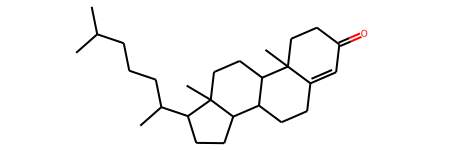

In [67]:
#myTrees is the table of tree files and the mass of each compound
myTrees = np.load(maxdepth_5_table) 

pactolus_hit_index = 6 #this is the index of either the spectrum being searched or the hit for that spectrum

hit_indices = np.argsort(pactolus_hits[pactolus_hit_index])[::-1]
hit_rank = 0 #this is the nth best hit for a search

fid = h5py.File( myTrees[ hit_indices[hit_rank] ][0] )
inchi_key = fid.keys()[0]
print inchi_key
url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/inchikey/%s/property/inchi/txt'%inchi_key
import requests
inchi = requests.get(url).content.strip().split('\n')[0]
print inchi

myMol = Chem.MolFromInchi(inchi)
myMol_w_Hs = Chem.AddHs(myMol)

for k in fid[fid.keys()[0]].keys():
    if 'max_depth=5' in k:
        tree_group = k
loc = '%s/%s'%(inchi_key,tree_group)
pactolus_tree = fid[loc][:]

#pactolus_result is the numerical score for a hit
#pactolus_match_matrix is the ion matches for each fragment.  Its #fragments long by #ions * #neutralizations wide.
pactolus_result, pactolus_match_matrix = score_frag_dag.calculate_MIDAS_score(arr[pactolus_hit_index],
                                                        pactolus_tree,
                                                        params['ms2_mass_tol'],
                                                        neutralizations = pos_mode_neutralizations,
                                                        want_match_matrix = True)


SVG(moltosvg(myMol))

In [68]:
# reshape the match matrix into size[#trees, #ions, #neutralizations]
numIons = arr[pactolus_hit_index].shape[0]
numFragments = pactolus_match_matrix.shape[0]
numNeutralizations = len(pos_mode_neutralizations)

rMM = np.zeros((numFragments,numIons,numNeutralizations))
for i in range(numFragments):
    myCounter = 0
    for k in range(numNeutralizations):
        for j in range(numIons):
            rMM[i,j,k] = pactolus_match_matrix[i,myCounter]
            myCounter = myCounter + 1


In [69]:
fragment_hits = np.argwhere(np.sum(np.sum(rMM,axis=2),axis=1)>0)


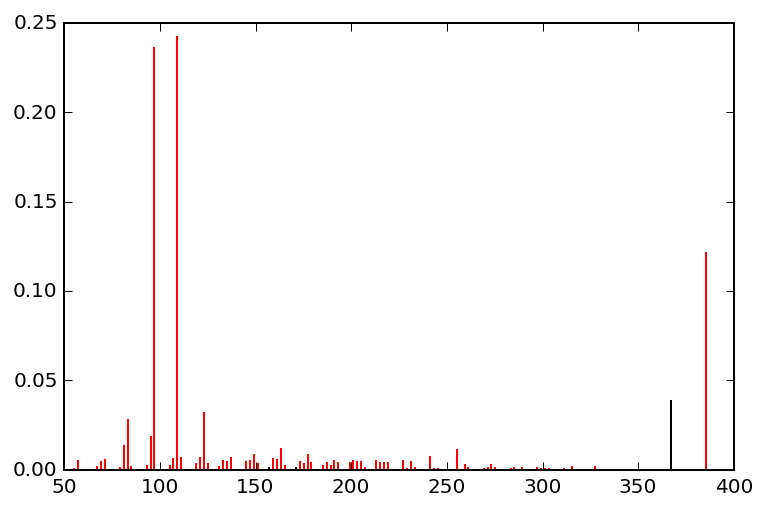

In [70]:
s = np.sum(rMM,axis=0)
idx_no_hit = np.argwhere( np.sum(s,axis=1) == 0 )
idx_hit = np.argwhere( np.sum(s,axis=1) > 0 )
plt.vlines(arr[pactolus_hit_index][idx_no_hit,0],
           np.zeros(len(idx_no_hit)),
           arr[pactolus_hit_index][idx_no_hit,1],
           colors='k')
plt.vlines(arr[pactolus_hit_index][idx_hit,0],
           np.zeros(len(idx_hit)),
           arr[pactolus_hit_index][idx_hit,1],
           colors='r')
plt.show()

In [89]:
print np.sum(np.sum(rMM,axis=0),axis=1)

[   0.   47.   12.   55.   59.    8.   22.   86.   73.    8.    3.   34.
  105.   74.    0.    6.   51.  116.   71.   14.   64.  116.   62.    1.
   26.   90.  118.    2.   38.  109.  117.    0.    6.   53.  116.  109.
    0.   11.   68.  124.  103.    2.   30.   96.  118.   85.    4.   63.
  136.  138.   86.    0.   15.   54.  160.  130.   31.   71.  187.   88.
   68.   31.   80.  214.   56.  227.   70.   63.  101.  284.   88.   71.
  108.   77.   56.  131.  160.   64.   62.  146.  136.    0.    1.]


(array([12, 13]),)
97.069519 0.236609434112


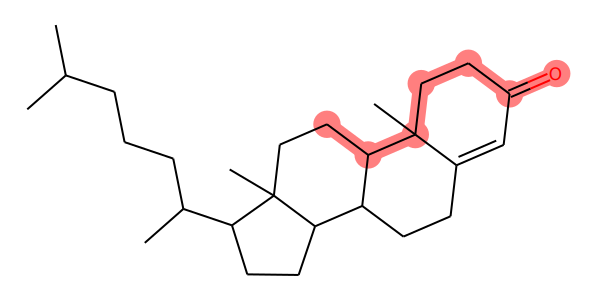

(array([12, 13]),)
97.069519 0.236609434112


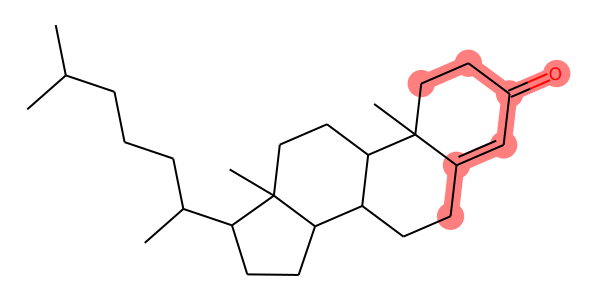

(array([12, 13]),)
97.069519 0.236609434112


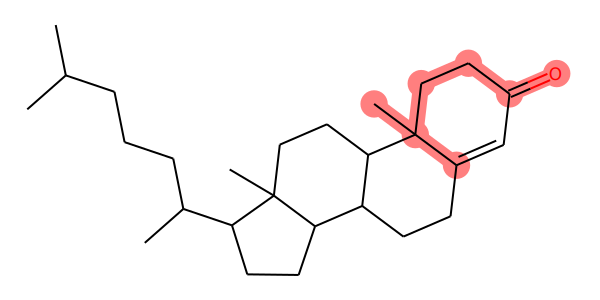

(array([12, 13]),)
97.069519 0.236609434112


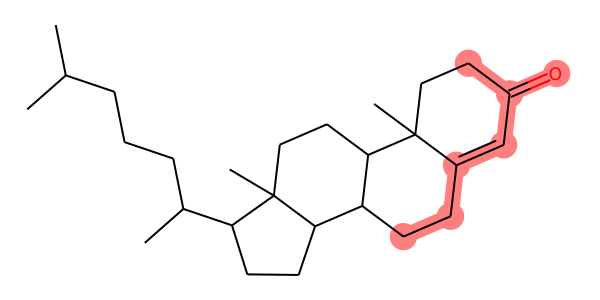

(array([12, 13]),)
97.069519 0.236609434112


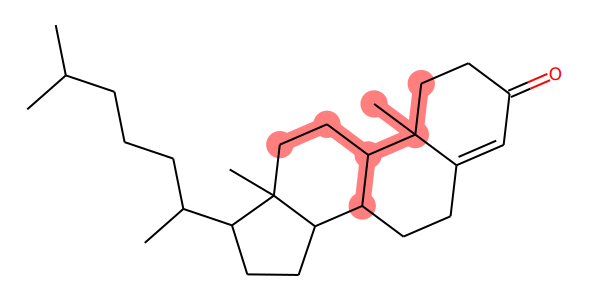

(array([12, 13]),)
97.069519 0.236609434112


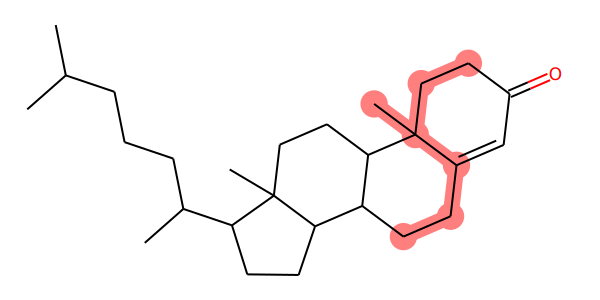

(array([12, 13]),)
97.069519 0.236609434112


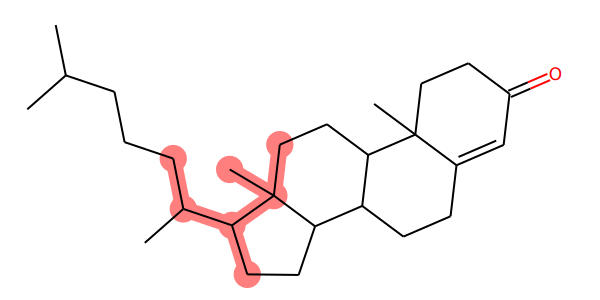

(array([12, 13]),)
97.069519 0.236609434112


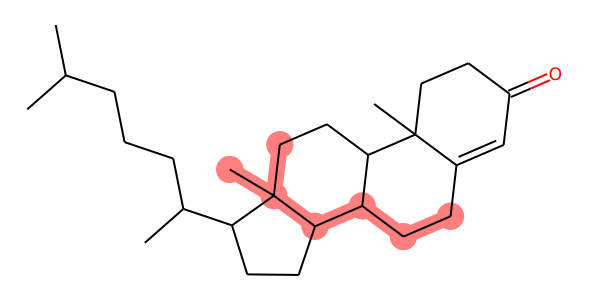

(array([12, 13]),)
97.069519 0.236609434112


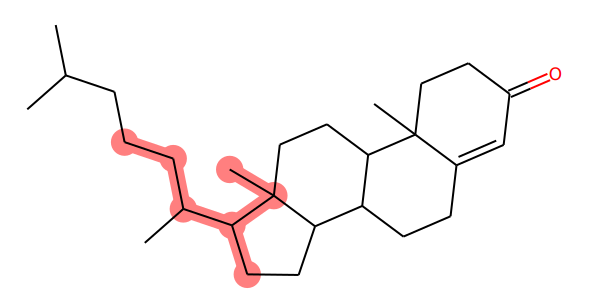

(array([12, 13]),)
97.069519 0.236609434112


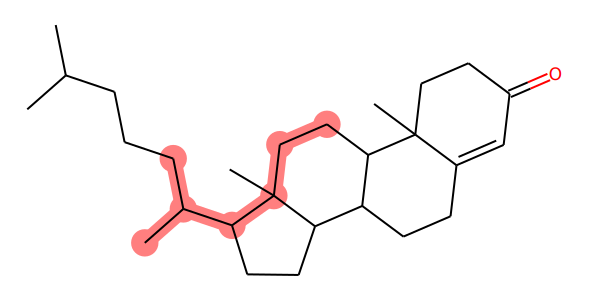

(array([12, 13]),)
97.069519 0.236609434112


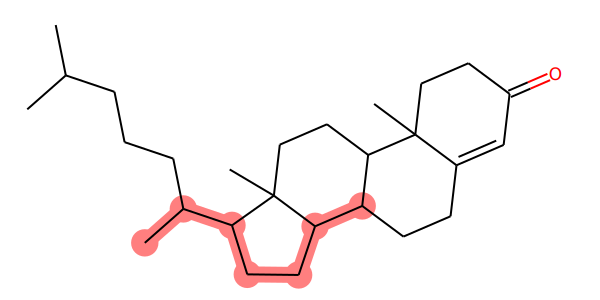

(array([12, 13]),)
97.069519 0.236609434112


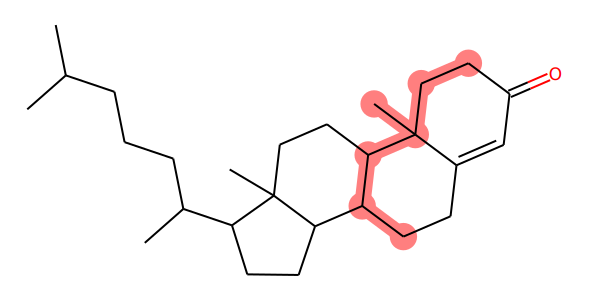

(array([12, 13]),)
97.069519 0.236609434112


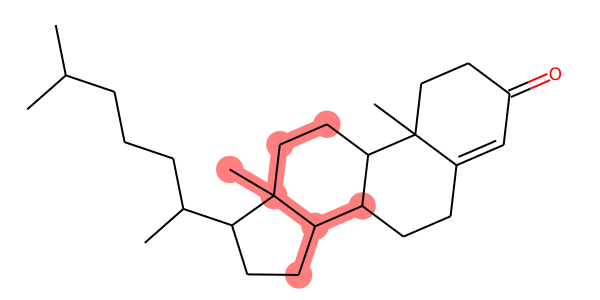

(array([12, 13]),)
97.069519 0.236609434112


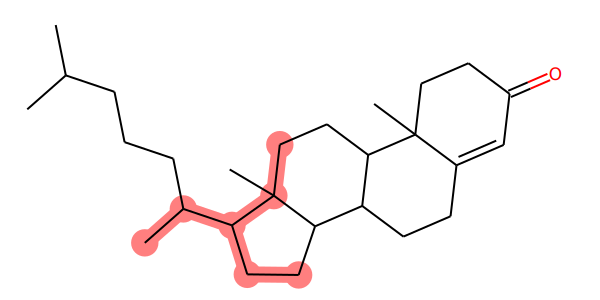

(array([12, 13]),)
97.069519 0.236609434112


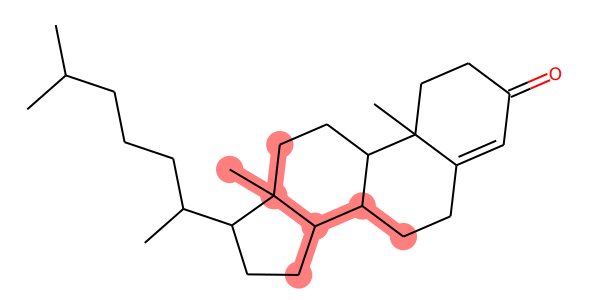

(array([12, 13]),)
97.069519 0.236609434112


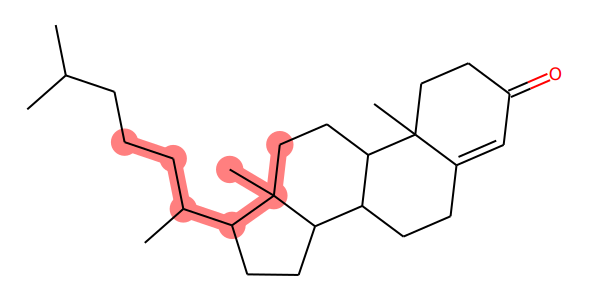

(array([12, 13]),)
97.069519 0.236609434112


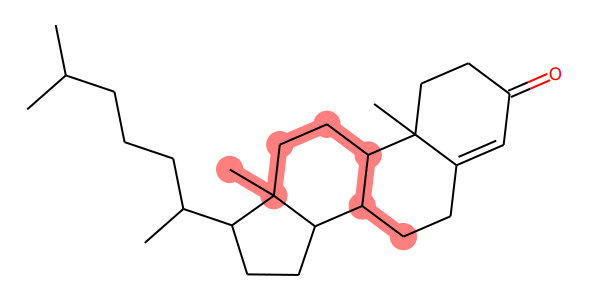

(array([12, 13]),)
97.069519 0.236609434112


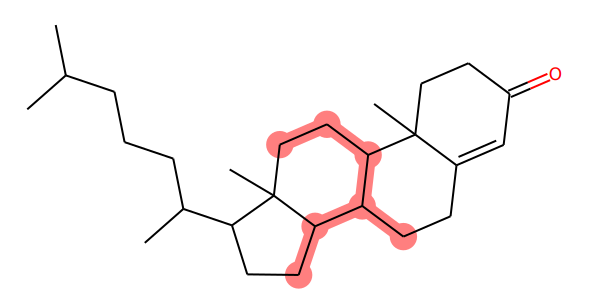

(array([12, 13]),)
97.069519 0.236609434112


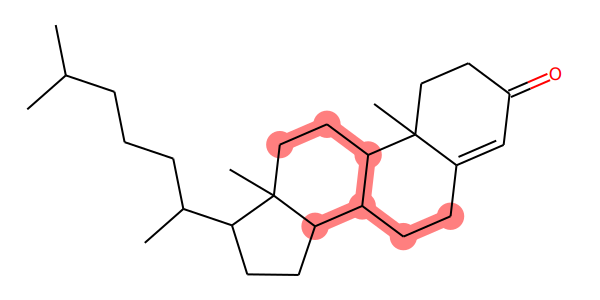

(array([12, 13]),)
97.069519 0.236609434112


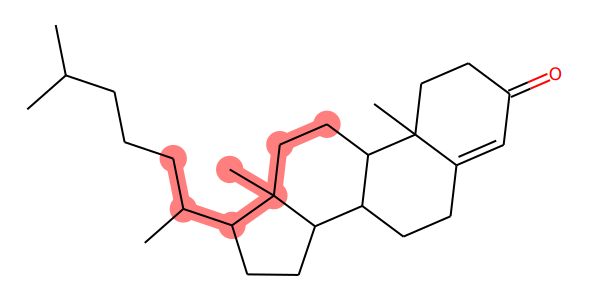

(array([12, 13]),)
97.069519 0.236609434112


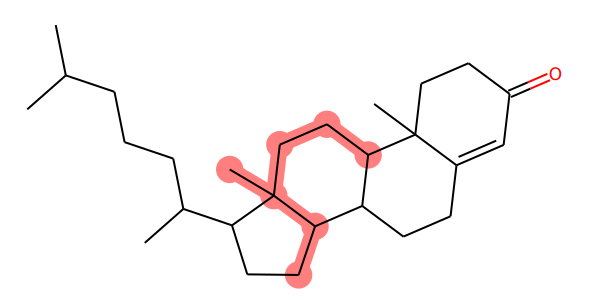

(array([12, 13]),)
97.069519 0.236609434112


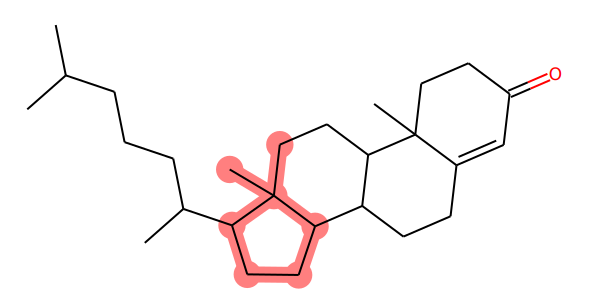

(array([12, 13]),)
97.069519 0.236609434112


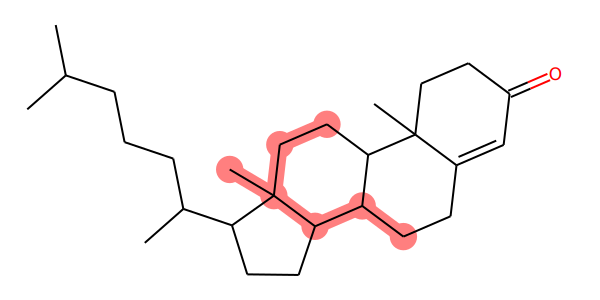

(array([12, 13]),)
97.069519 0.236609434112


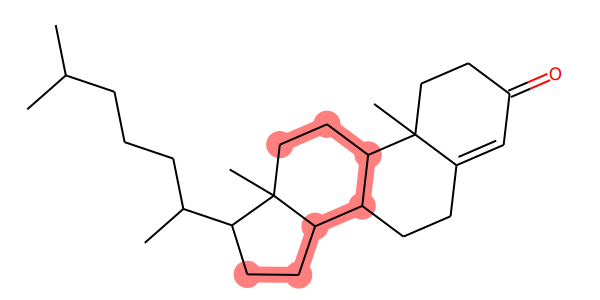

(array([12, 13]),)
97.069519 0.236609434112


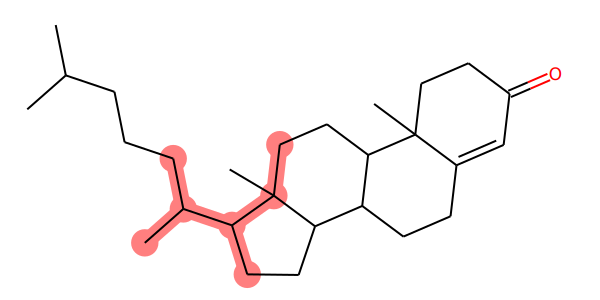

(array([12, 13]),)
97.069519 0.236609434112


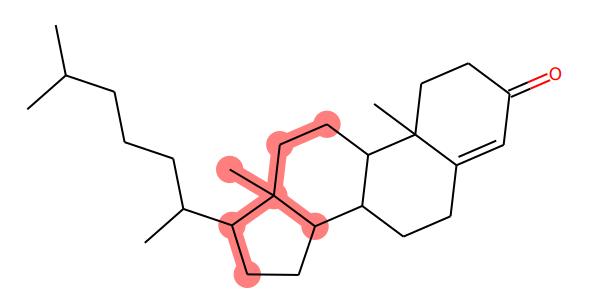

(array([12, 13]),)
97.069519 0.236609434112


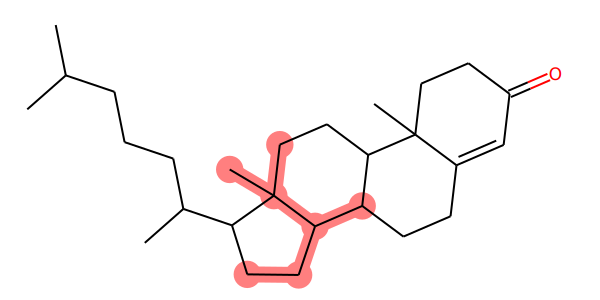

(array([12, 13]),)
97.069519 0.236609434112


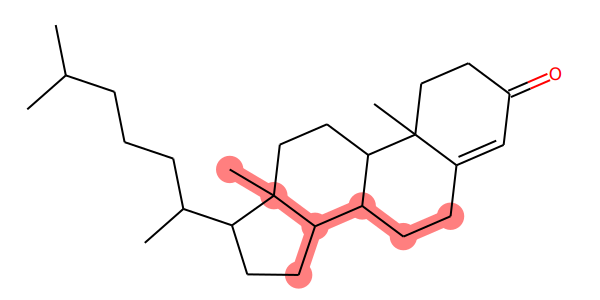

(array([12, 13]),)
97.069519 0.236609434112


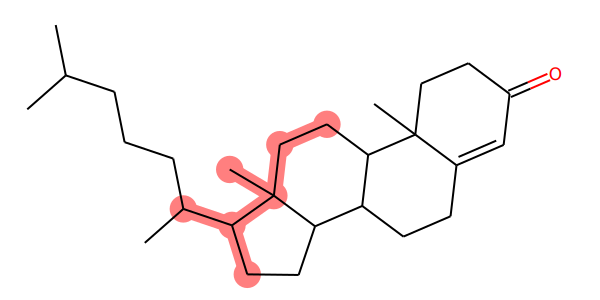

(array([12, 13]),)
97.069519 0.236609434112


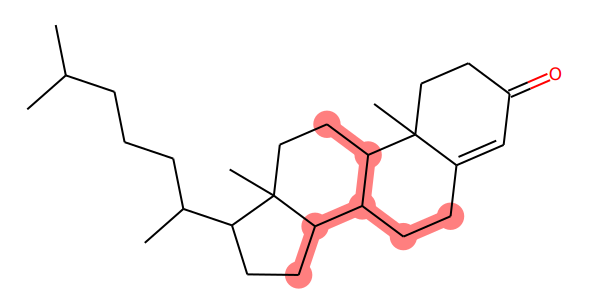

(array([12, 13]),)
97.069519 0.236609434112


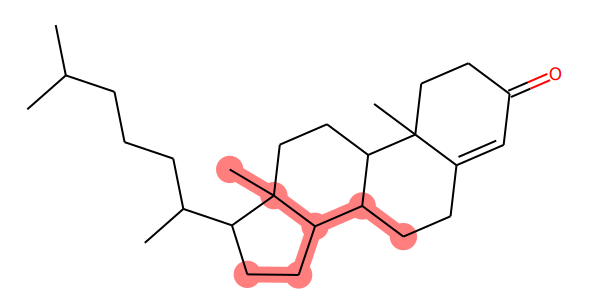

(array([12, 13]),)
97.069519 0.236609434112


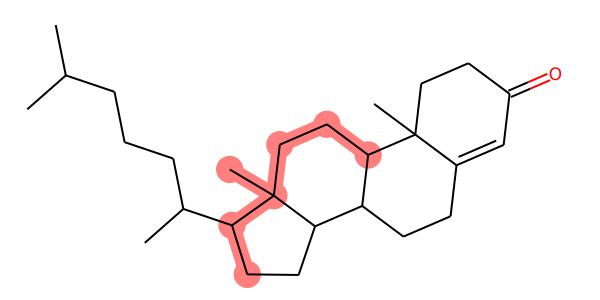

(array([12, 13]),)
97.069519 0.236609434112


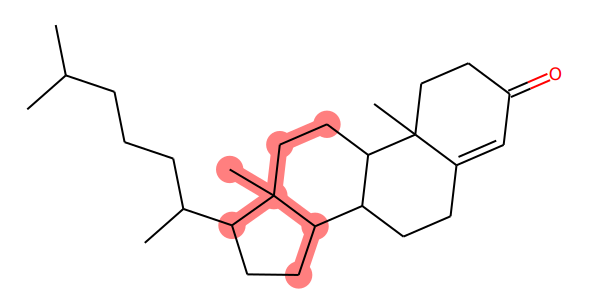

(array([12, 13]),)
97.069519 0.236609434112


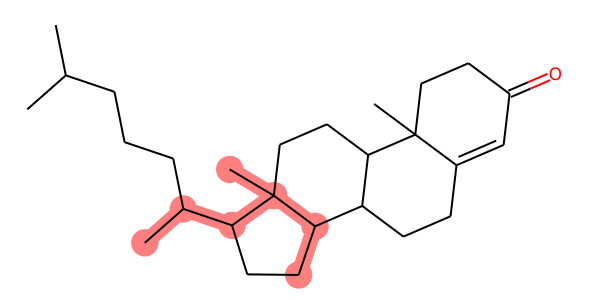

(array([12, 13]),)
97.069519 0.236609434112


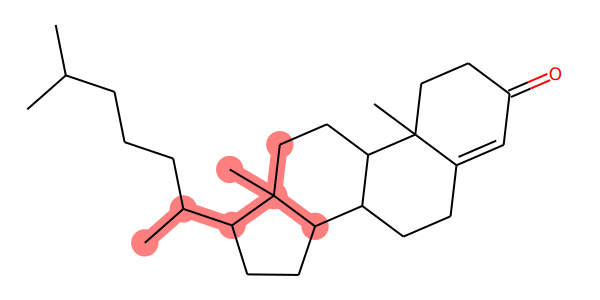

(array([12, 13]),)
97.069519 0.236609434112


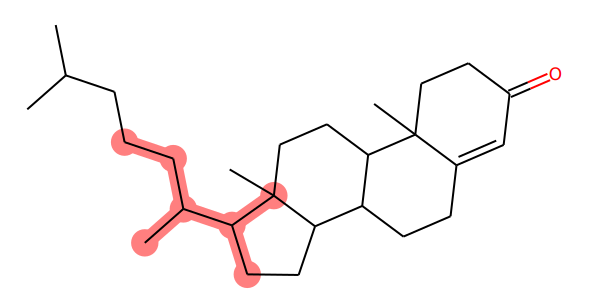

(array([12, 13]),)
97.069519 0.236609434112


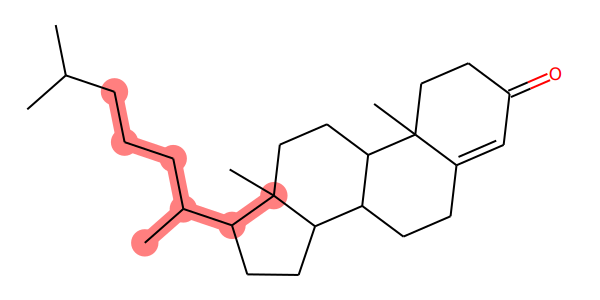

(array([12, 13]),)
97.069519 0.236609434112


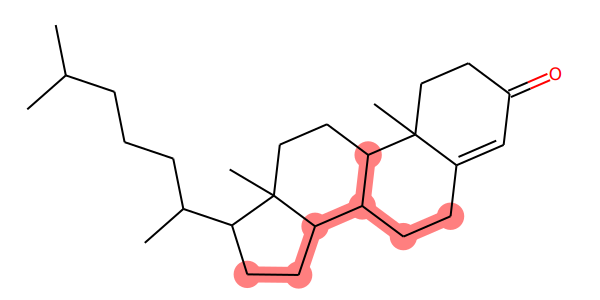

(array([12, 13]),)
97.069519 0.236609434112


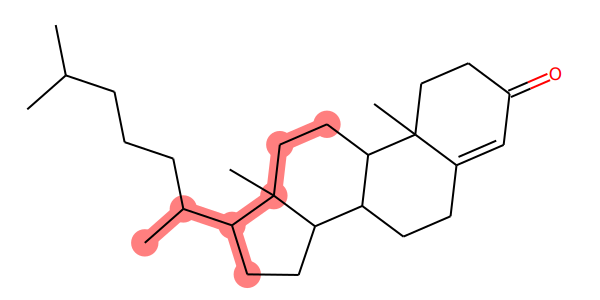

(array([12, 13]),)
97.069519 0.236609434112


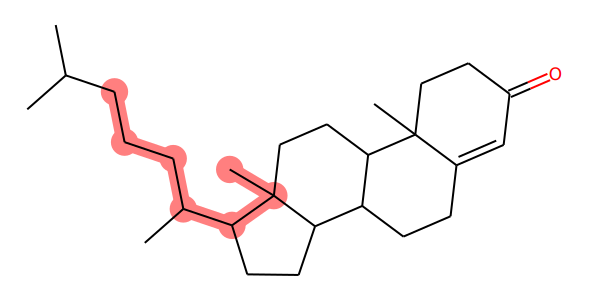

(array([12, 13]),)
97.069519 0.236609434112


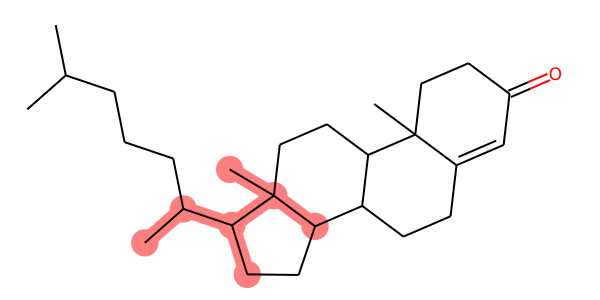

(array([12, 13]),)
97.069519 0.236609434112


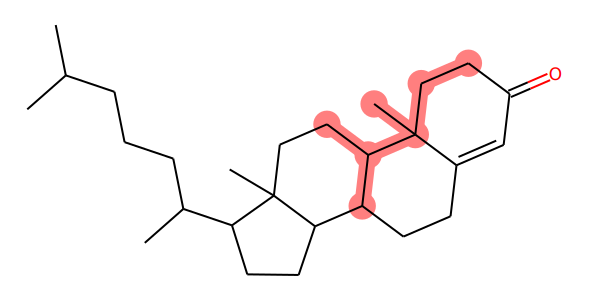

(array([12, 13]),)
97.069519 0.236609434112


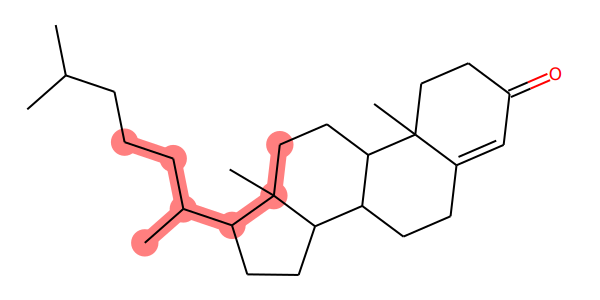

(array([12, 13]),)
97.069519 0.236609434112


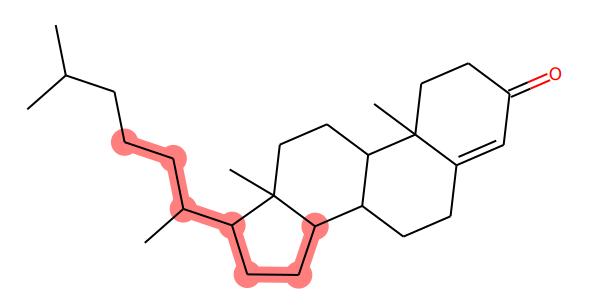

(array([12, 13]),)
97.069519 0.236609434112


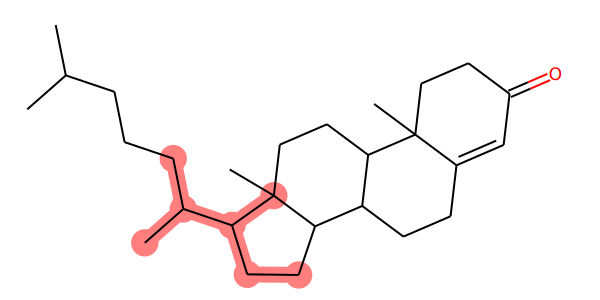

(array([12, 13]),)
97.069519 0.236609434112


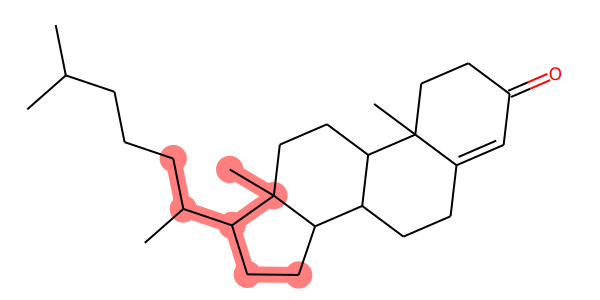

(array([12, 13]),)
97.069519 0.236609434112


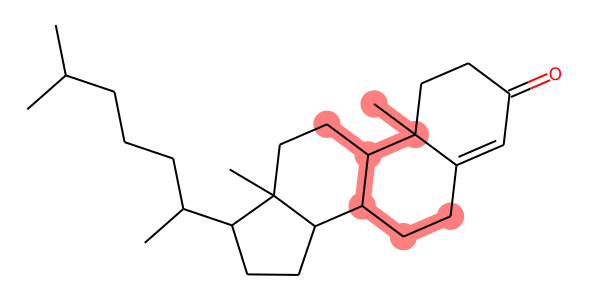

(array([12, 13]),)
97.069519 0.236609434112


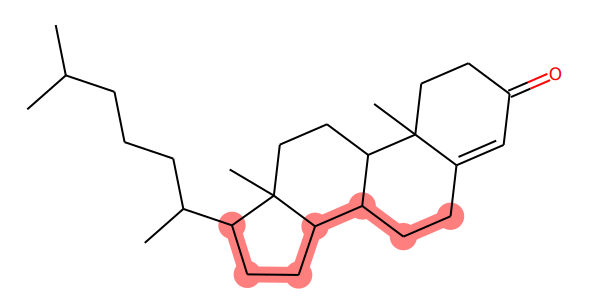

(array([12, 13]),)
97.069519 0.236609434112


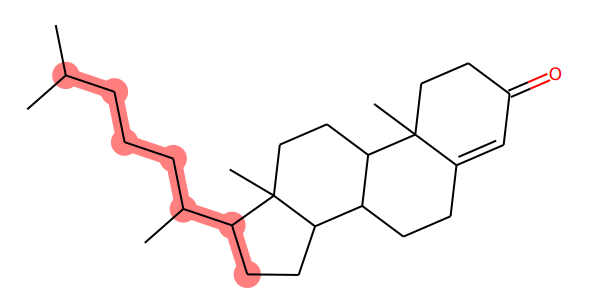

(array([12, 13]),)
97.069519 0.236609434112


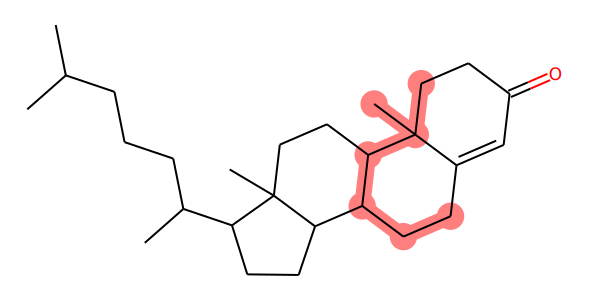

(array([12, 13]),)
97.069519 0.236609434112


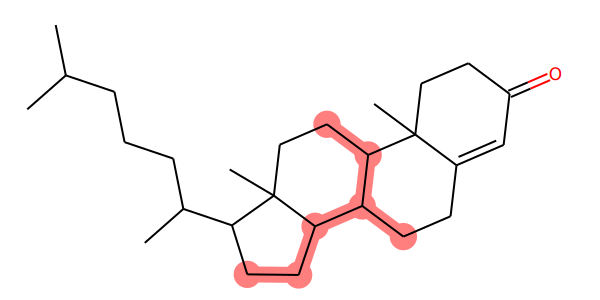

(array([12, 13]),)
97.069519 0.236609434112


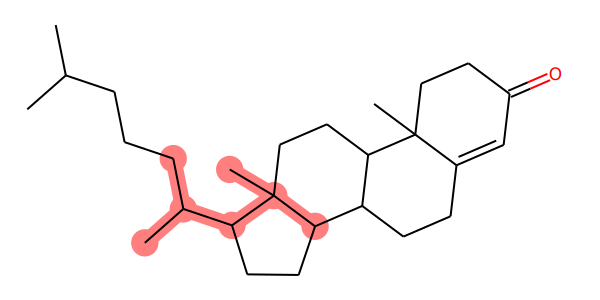

(array([12, 13]),)
97.069519 0.236609434112


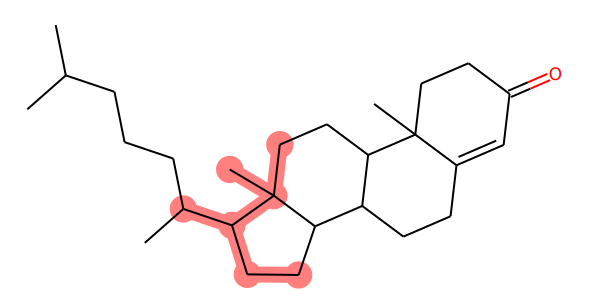

(array([12, 13]),)
97.069519 0.236609434112


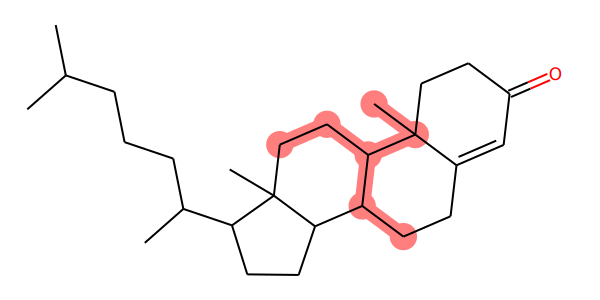

(array([12, 13]),)
97.069519 0.236609434112


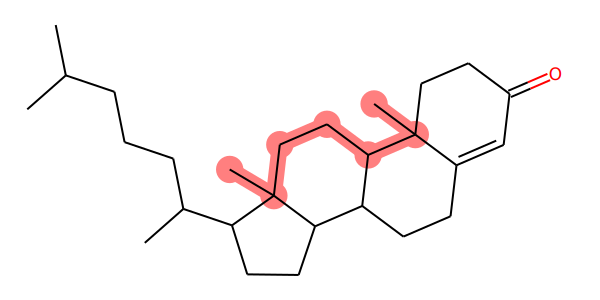

(array([12, 13]),)
97.069519 0.236609434112


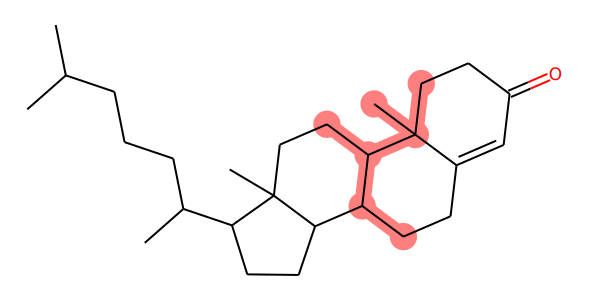

(array([13]),)
97.069519 0.236609434112


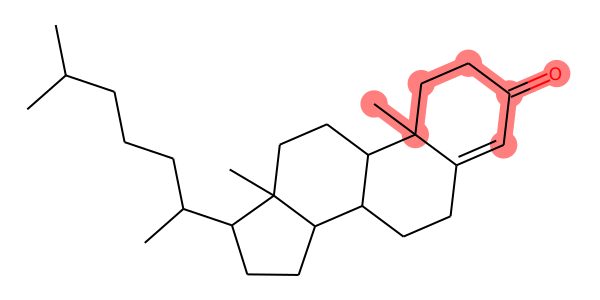

(array([13]),)
97.069519 0.236609434112


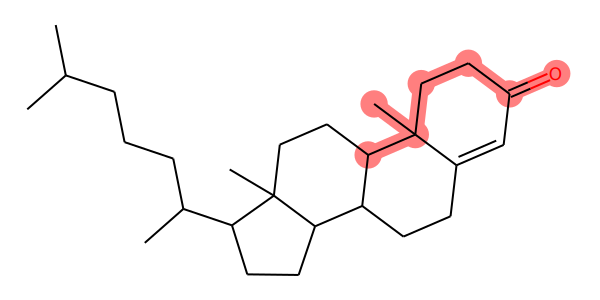

(array([13]),)
97.069519 0.236609434112


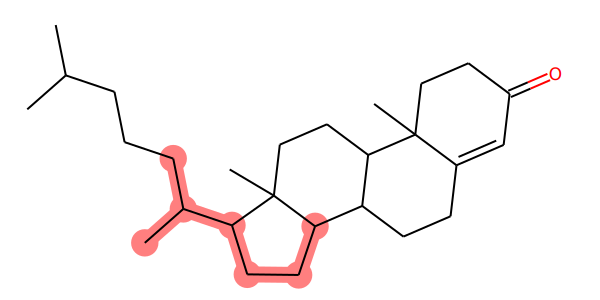

(array([13]),)
97.069519 0.236609434112


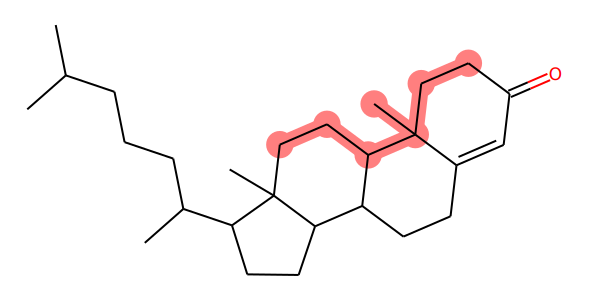

(array([13]),)
97.069519 0.236609434112


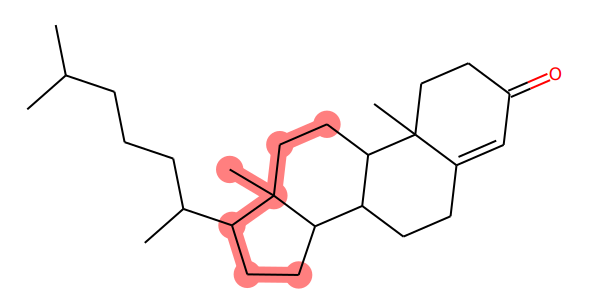

(array([13]),)
97.069519 0.236609434112


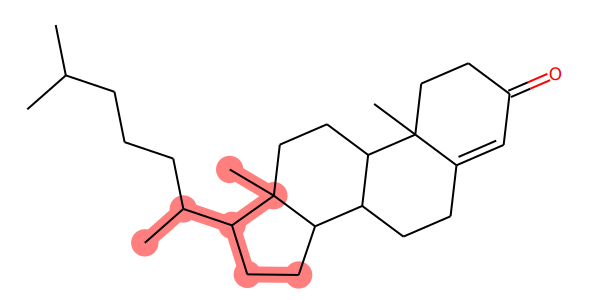

(array([13]),)
97.069519 0.236609434112


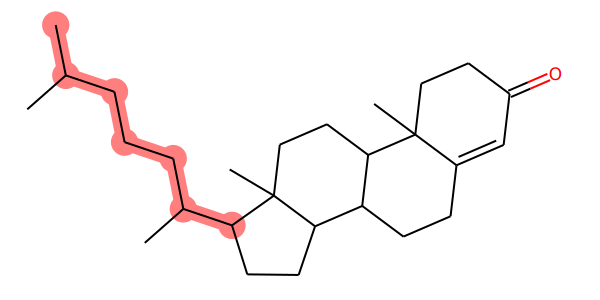

(array([13]),)
97.069519 0.236609434112


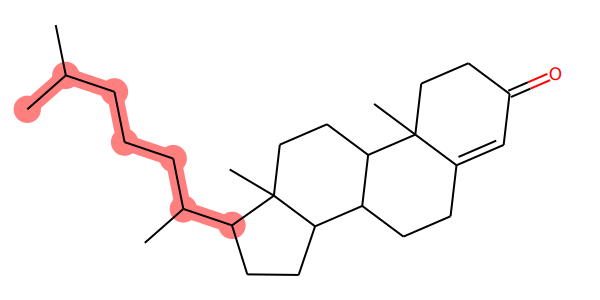

(array([13]),)
97.069519 0.236609434112


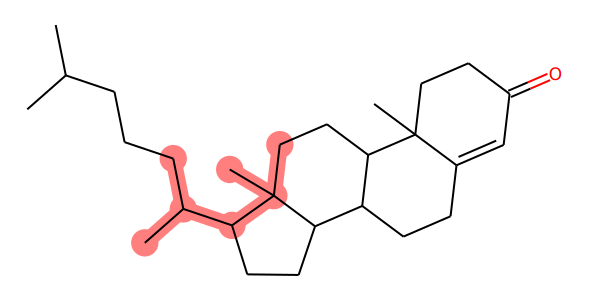

(array([13]),)
97.069519 0.236609434112


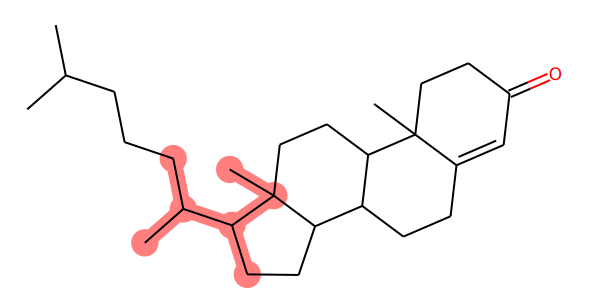

(array([13]),)
97.069519 0.236609434112


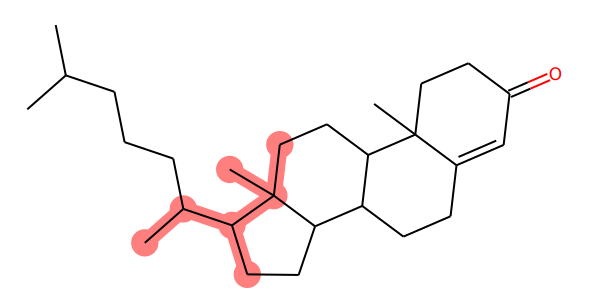

(array([13]),)
97.069519 0.236609434112


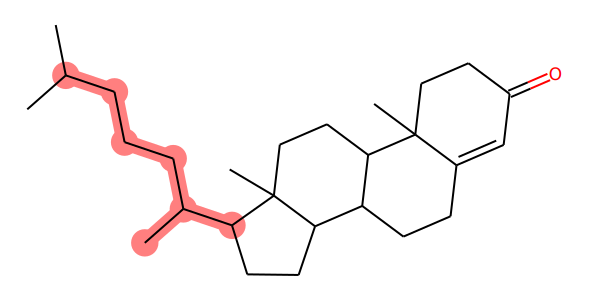

(array([13]),)
97.069519 0.236609434112


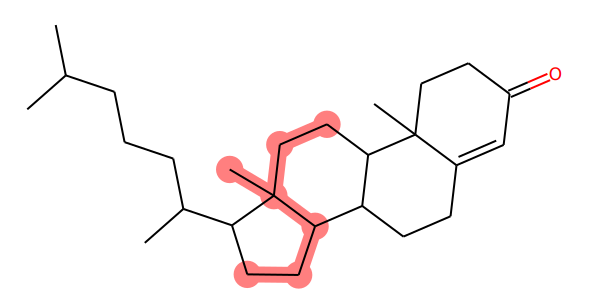

(array([13]),)
97.069519 0.236609434112


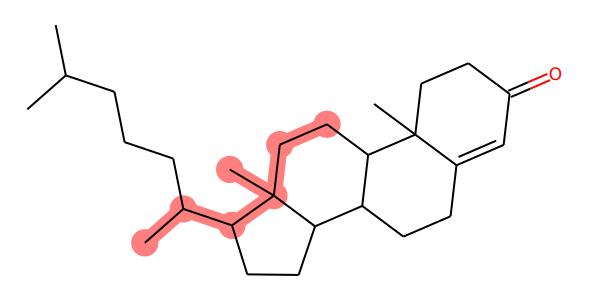

(array([13]),)
97.069519 0.236609434112


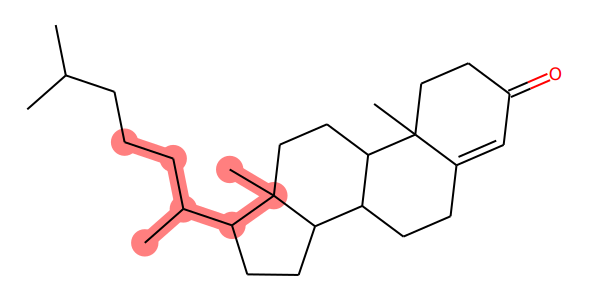

(array([13]),)
97.069519 0.236609434112


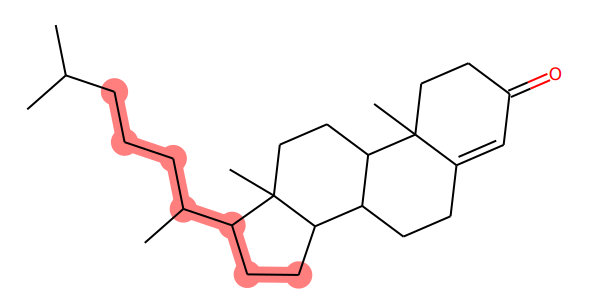

(array([13]),)
97.069519 0.236609434112


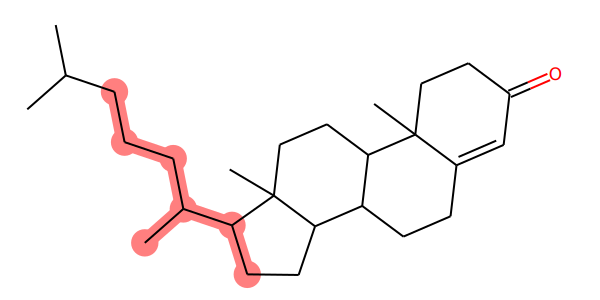

(array([13]),)
97.069519 0.236609434112


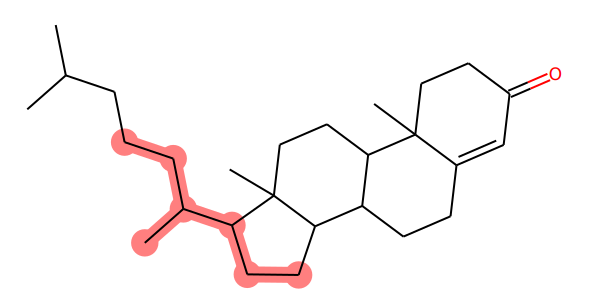

(array([16, 17]),)
109.0709 0.243084053366


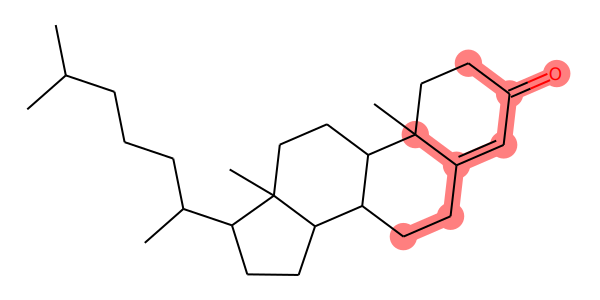

(array([16, 17]),)
109.0709 0.243084053366


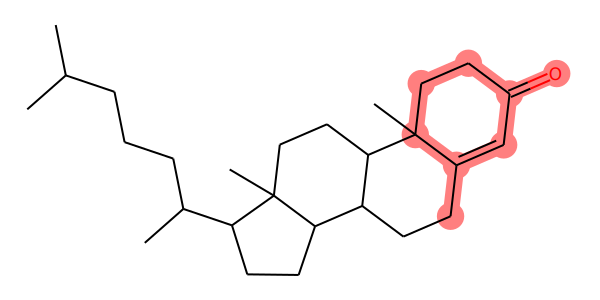

(array([16, 17]),)
109.0709 0.243084053366


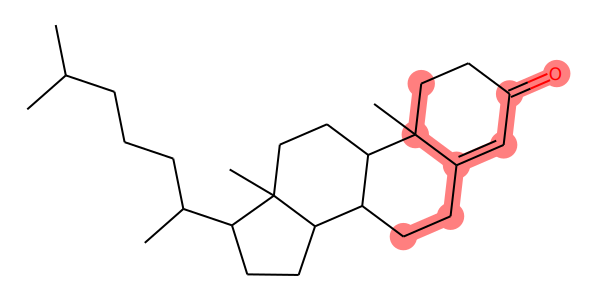

(array([16, 17]),)
109.0709 0.243084053366


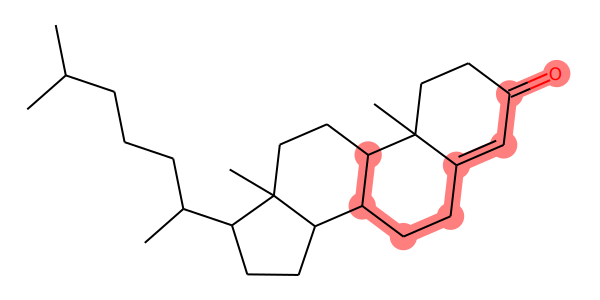

(array([16, 17]),)
109.0709 0.243084053366


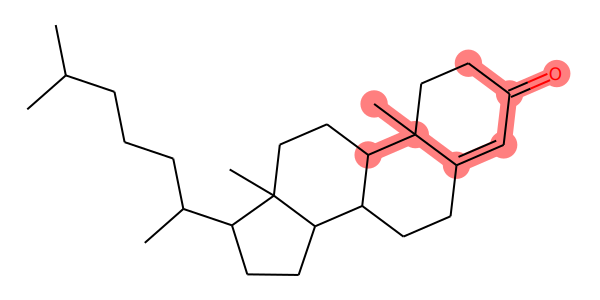

(array([16, 17]),)
109.0709 0.243084053366


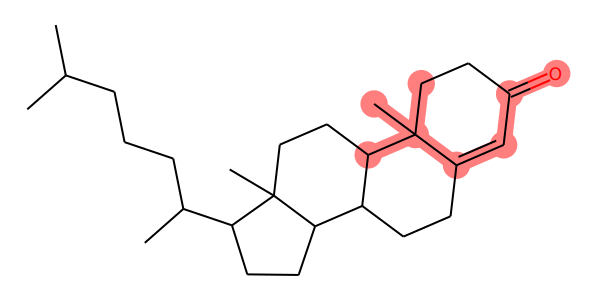

(array([16, 17]),)
109.0709 0.243084053366


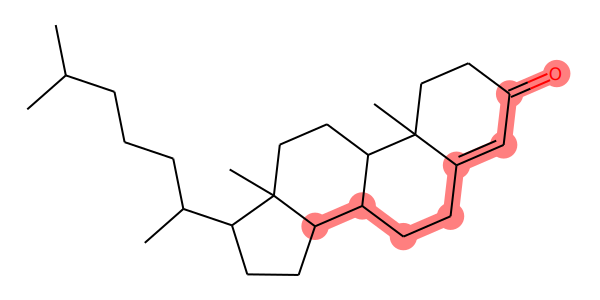

(array([16, 17]),)
109.0709 0.243084053366


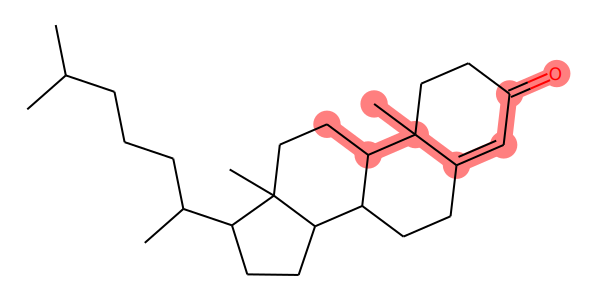

(array([16, 17]),)
109.0709 0.243084053366


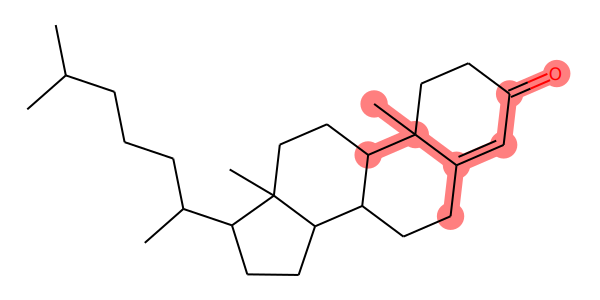

(array([16, 17]),)
109.0709 0.243084053366


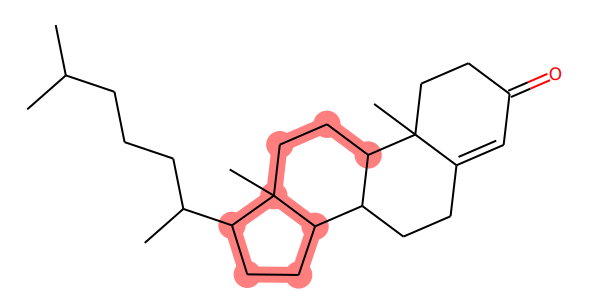

(array([16, 17]),)
109.0709 0.243084053366


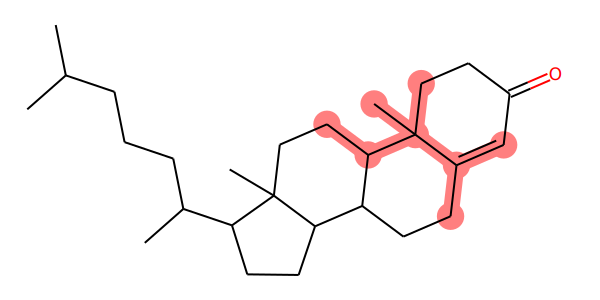

(array([16, 17]),)
109.0709 0.243084053366


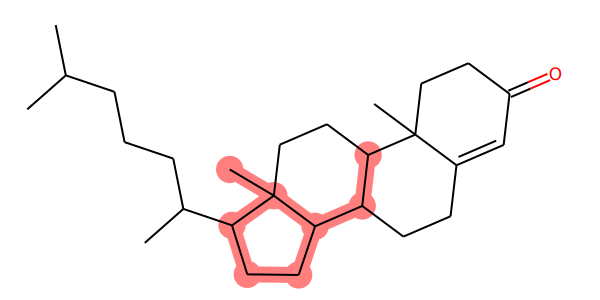

(array([16, 17]),)
109.0709 0.243084053366


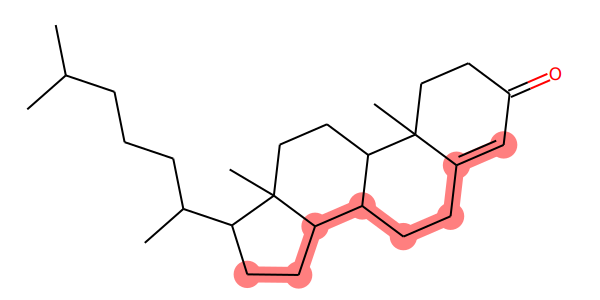

(array([16, 17]),)
109.0709 0.243084053366


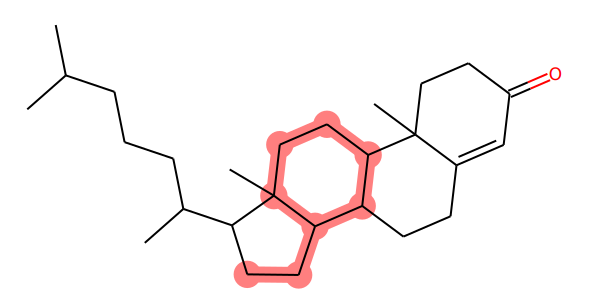

(array([16, 17]),)
109.0709 0.243084053366


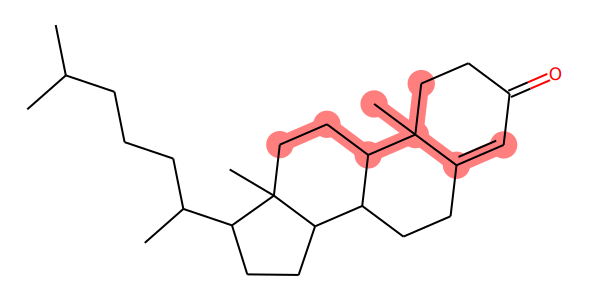

(array([16, 17]),)
109.0709 0.243084053366


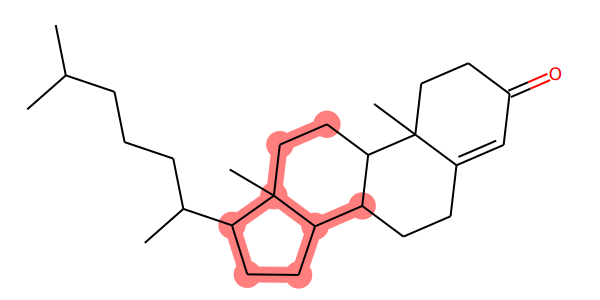

(array([16, 17]),)
109.0709 0.243084053366


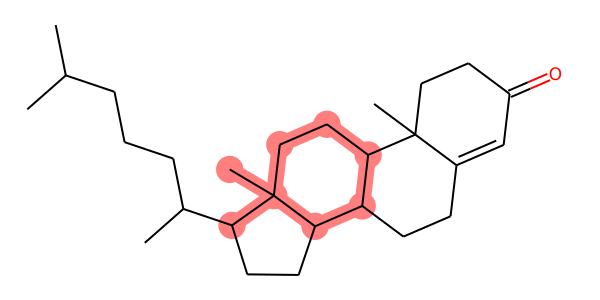

(array([16, 17]),)
109.0709 0.243084053366


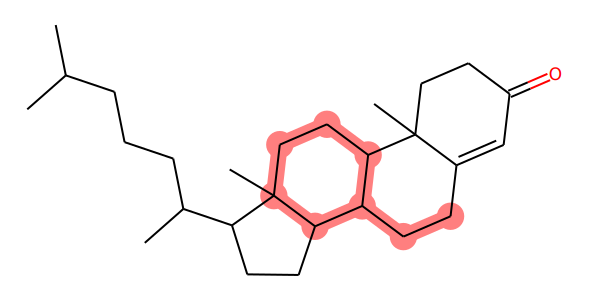

(array([16, 17]),)
109.0709 0.243084053366


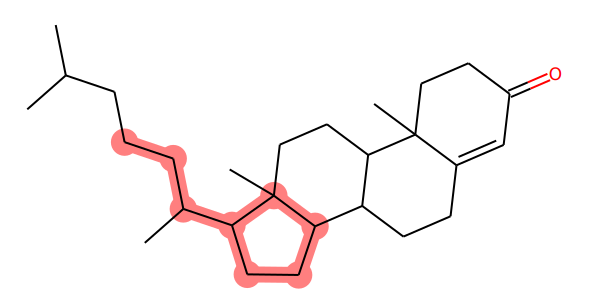

(array([16, 17]),)
109.0709 0.243084053366


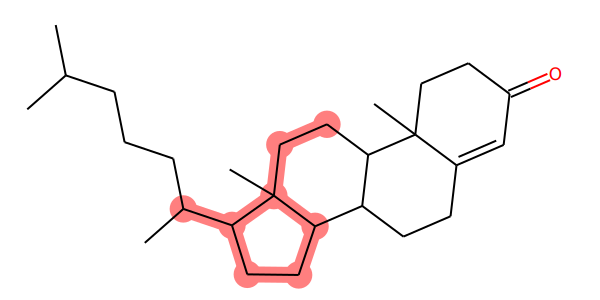

(array([16, 17]),)
109.0709 0.243084053366


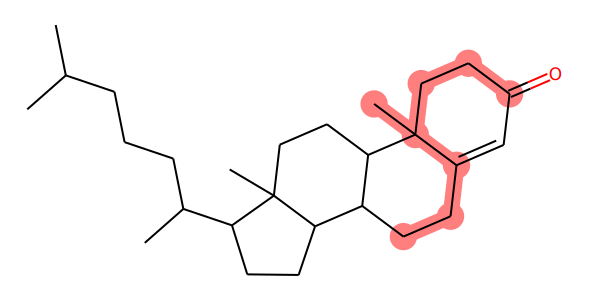

(array([16, 17]),)
109.0709 0.243084053366


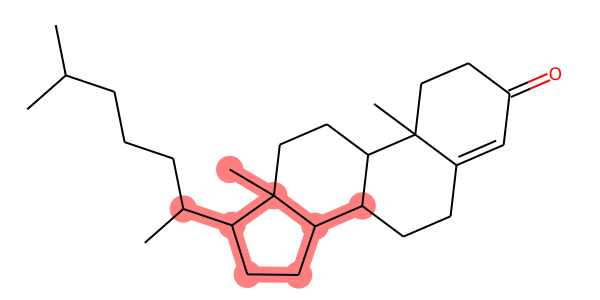

(array([16, 17]),)
109.0709 0.243084053366


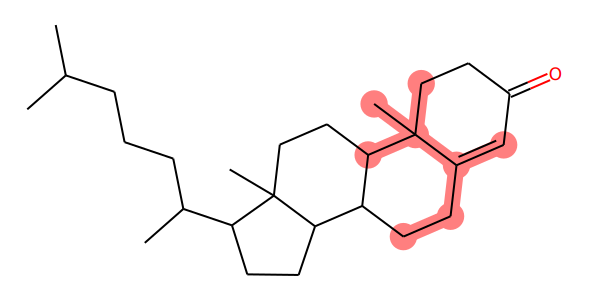

(array([16, 17]),)
109.0709 0.243084053366


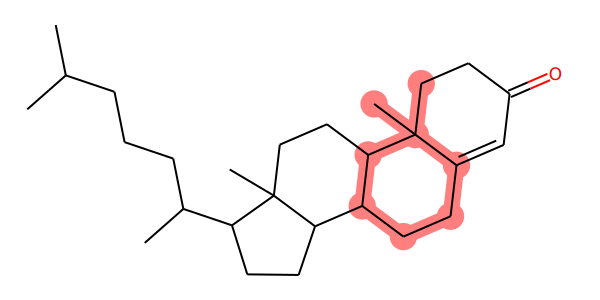

(array([16, 17]),)
109.0709 0.243084053366


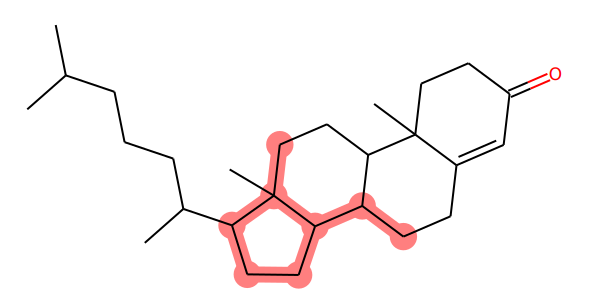

(array([16, 17]),)
109.0709 0.243084053366


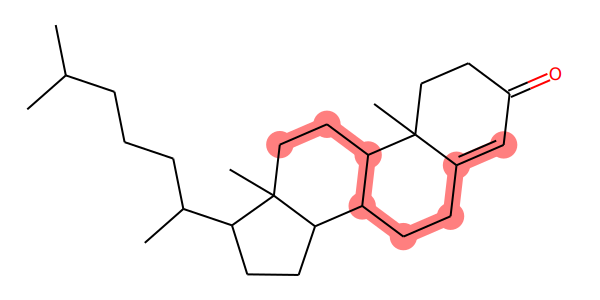

(array([16, 17]),)
109.0709 0.243084053366


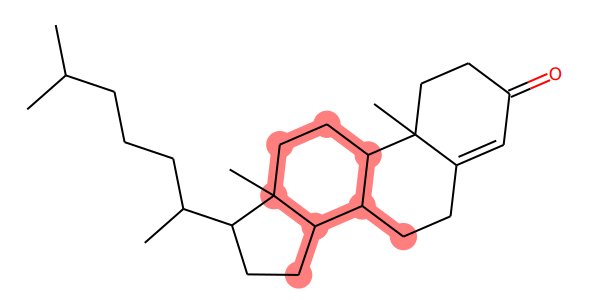

(array([16, 17]),)
109.0709 0.243084053366


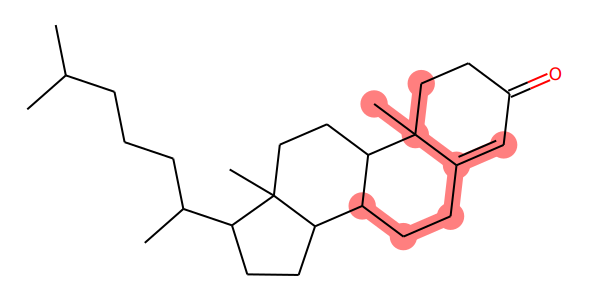

(array([16, 17]),)
109.0709 0.243084053366


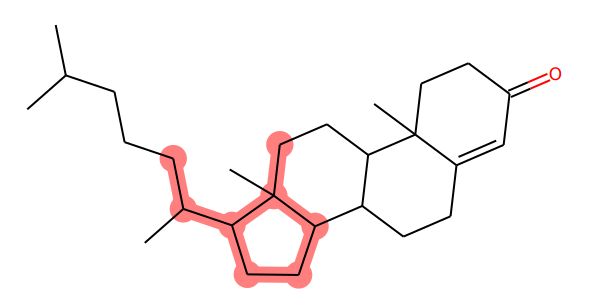

(array([16, 17]),)
109.0709 0.243084053366


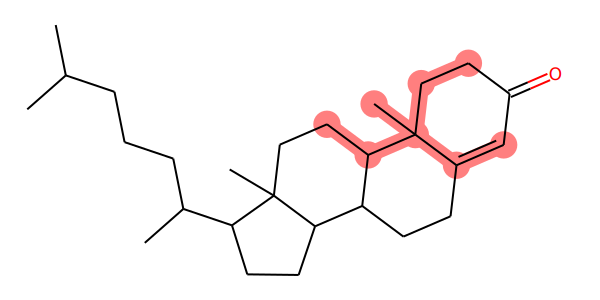

(array([16, 17]),)
109.0709 0.243084053366


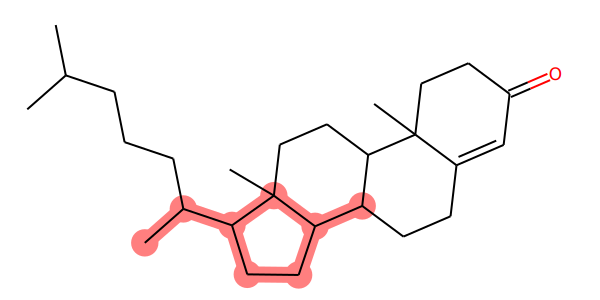

(array([16, 17]),)
109.0709 0.243084053366


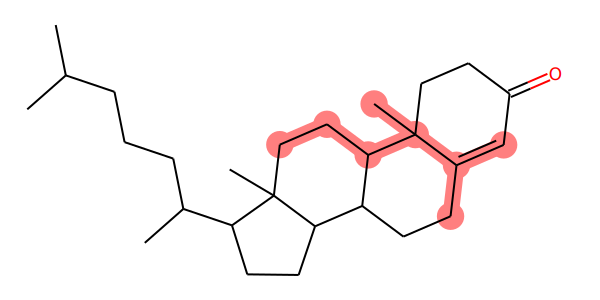

(array([16, 17]),)
109.0709 0.243084053366


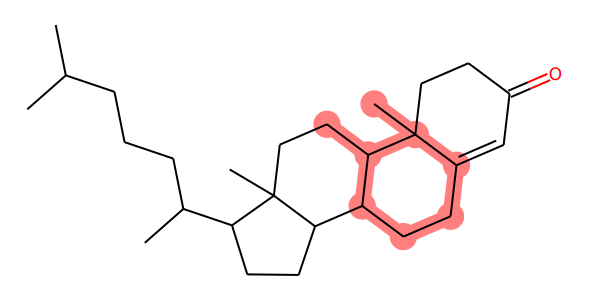

(array([16, 17]),)
109.0709 0.243084053366


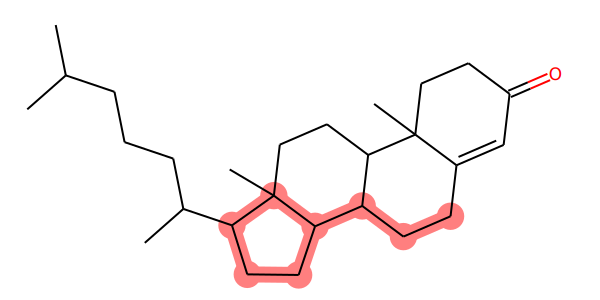

(array([16, 17]),)
109.0709 0.243084053366


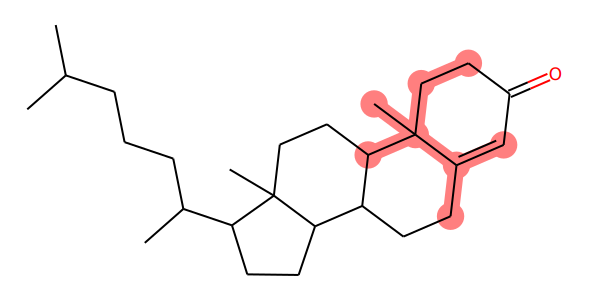

(array([16, 17]),)
109.0709 0.243084053366


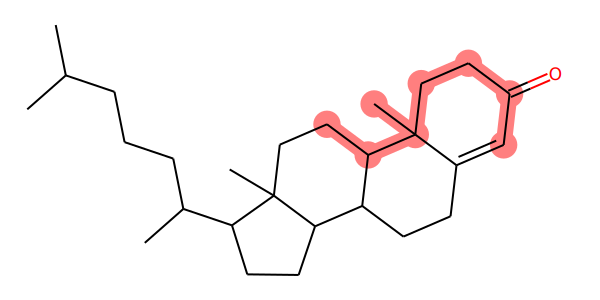

(array([16, 17]),)
109.0709 0.243084053366


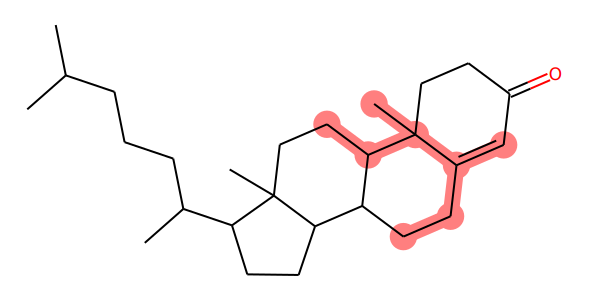

(array([17]),)
109.0709 0.243084053366


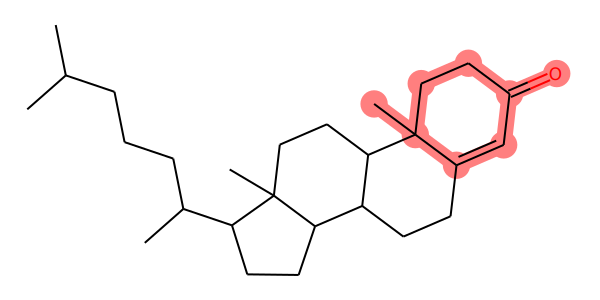

(array([17]),)
109.0709 0.243084053366


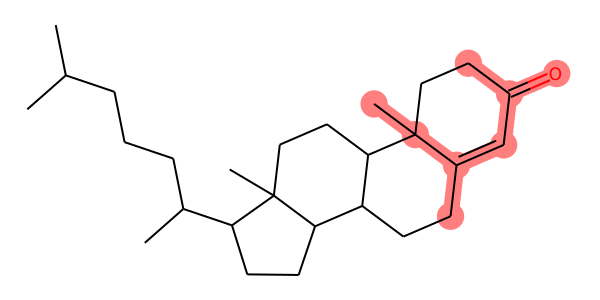

(array([17]),)
109.0709 0.243084053366


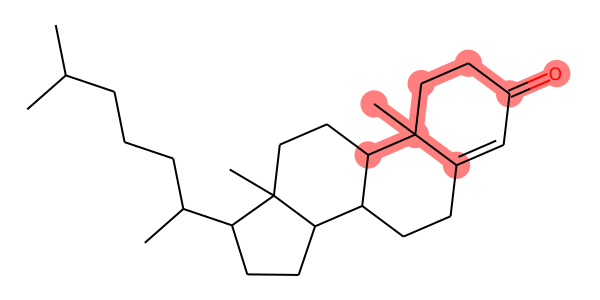

(array([17]),)
109.0709 0.243084053366


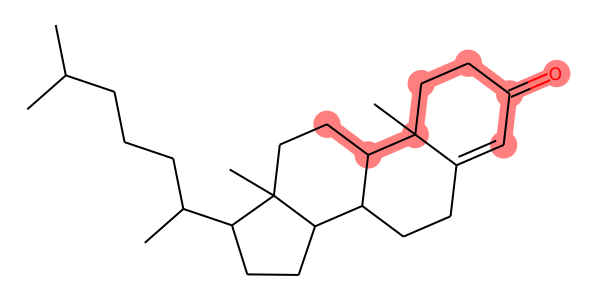

(array([17]),)
109.0709 0.243084053366


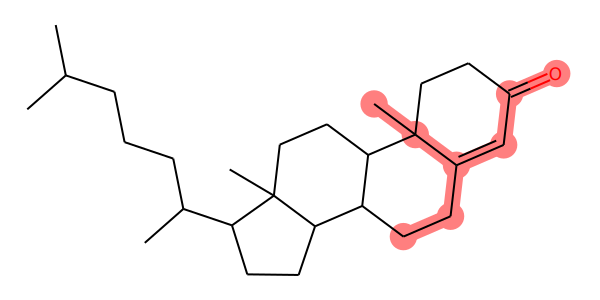

(array([17]),)
109.0709 0.243084053366


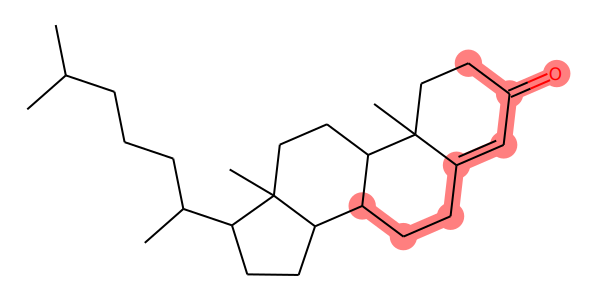

(array([17]),)
109.0709 0.243084053366


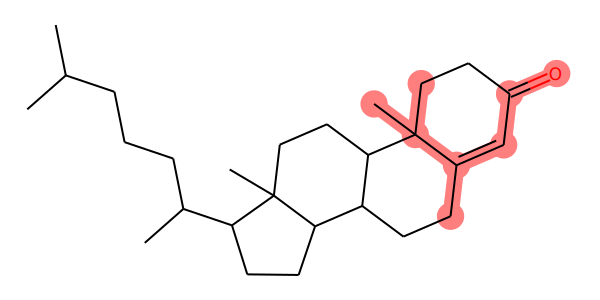

(array([17]),)
109.0709 0.243084053366


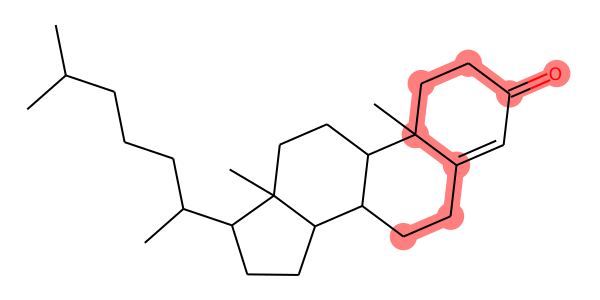

(array([17]),)
109.0709 0.243084053366


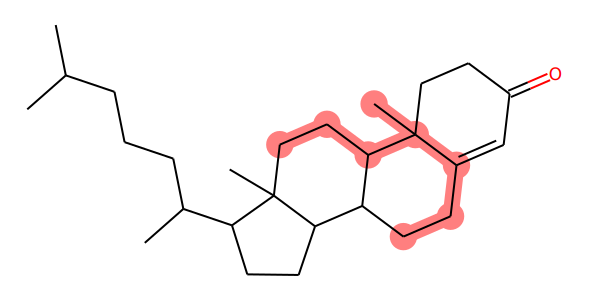

(array([17]),)
109.0709 0.243084053366


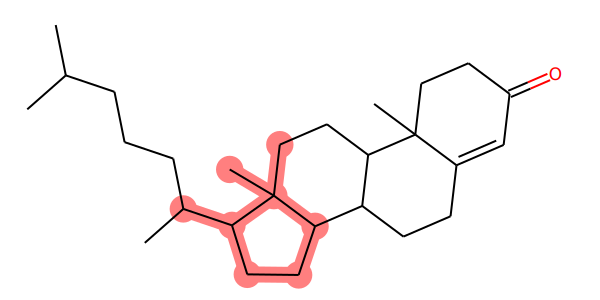

(array([17]),)
109.0709 0.243084053366


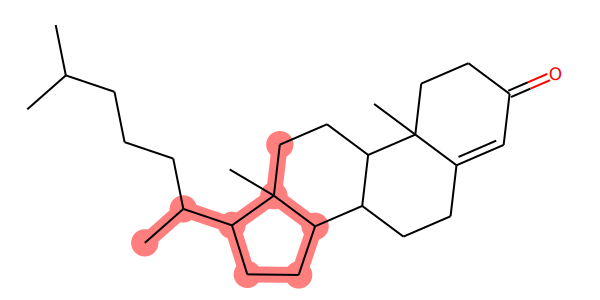

(array([17]),)
109.0709 0.243084053366


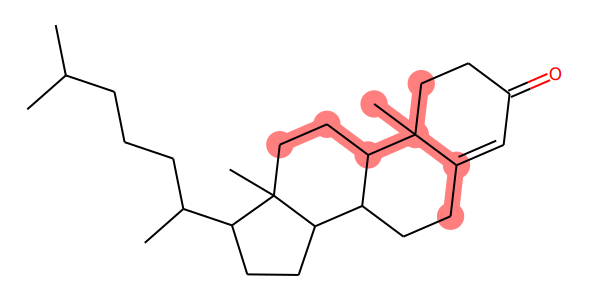

(array([17]),)
109.0709 0.243084053366


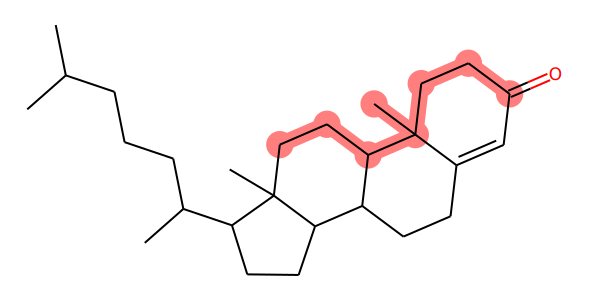

(array([17]),)
109.0709 0.243084053366


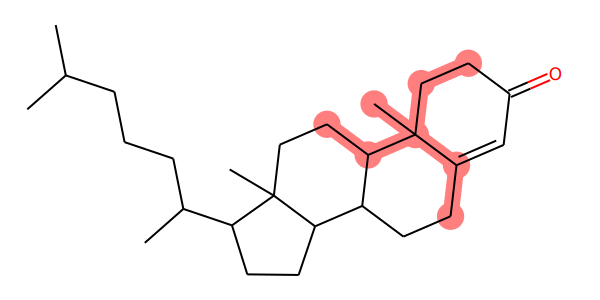

(array([17]),)
109.0709 0.243084053366


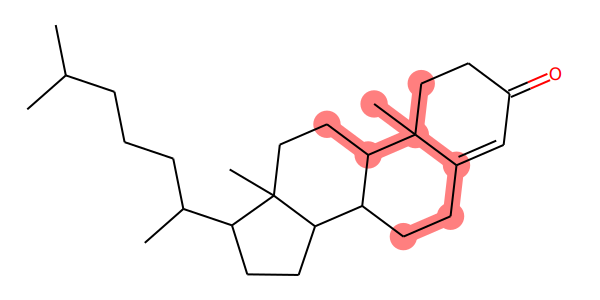

(array([17]),)
109.0709 0.243084053366


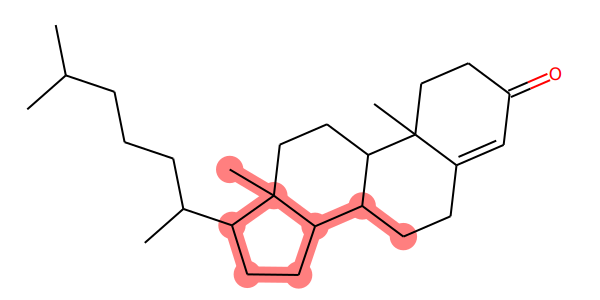

(array([17]),)
109.0709 0.243084053366


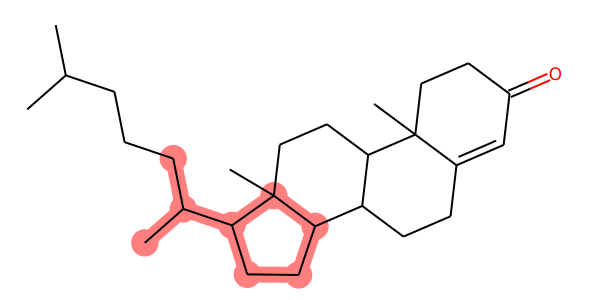

(array([17]),)
109.0709 0.243084053366


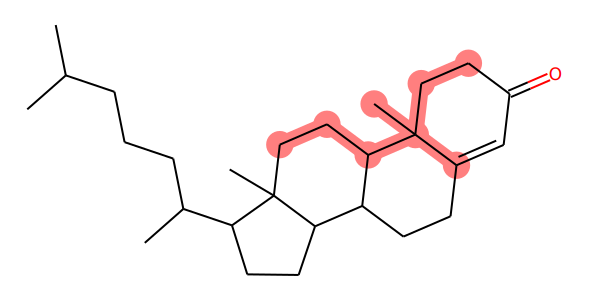

(array([17]),)
109.0709 0.243084053366


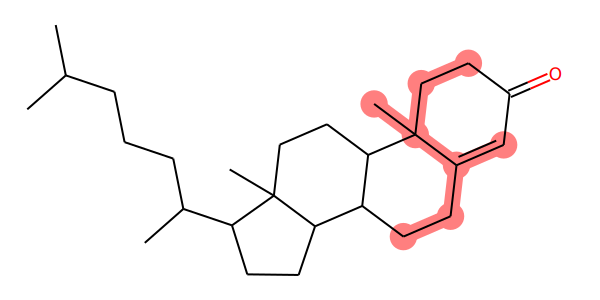

(array([17]),)
109.0709 0.243084053366


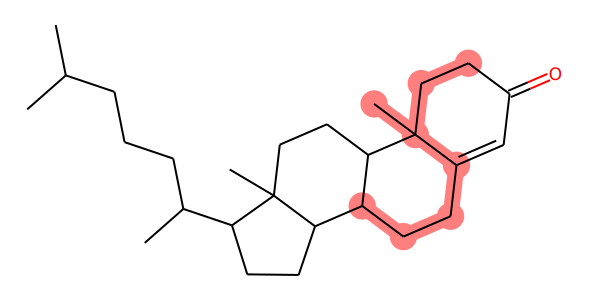

(array([17]),)
109.0709 0.243084053366


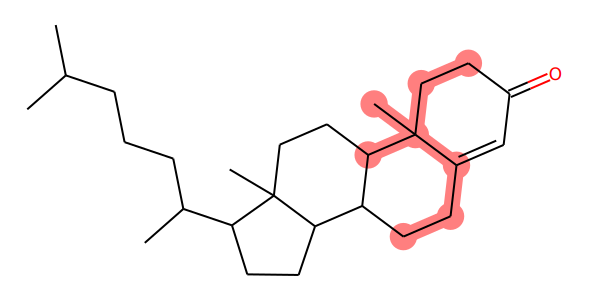

(array([17]),)
109.0709 0.243084053366


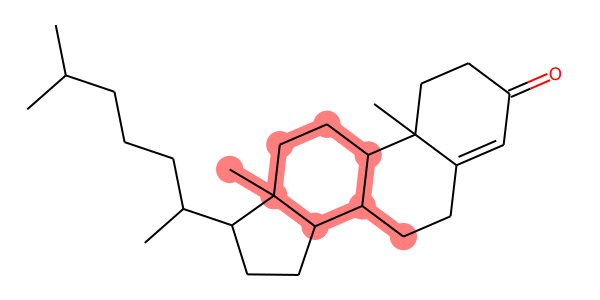

(array([17]),)
109.0709 0.243084053366


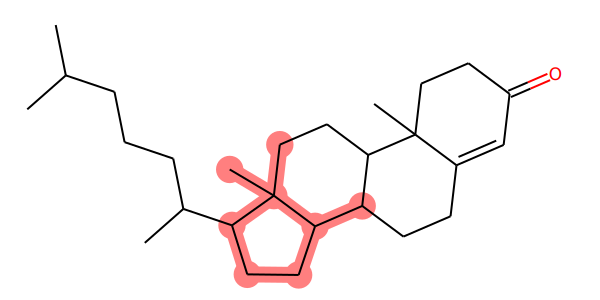

(array([17]),)
109.0709 0.243084053366


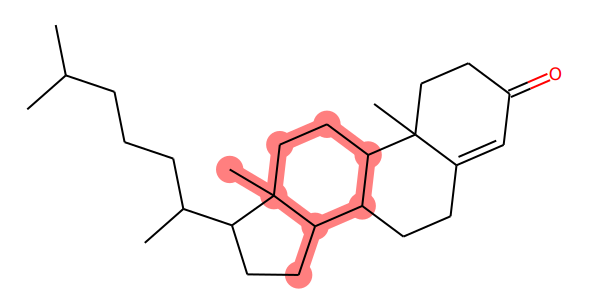

(array([17]),)
109.0709 0.243084053366


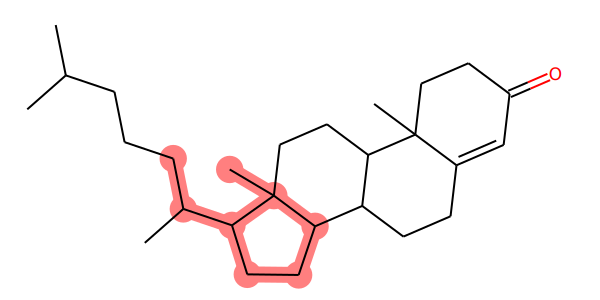

(array([17, 18]),)
109.0709 0.243084053366


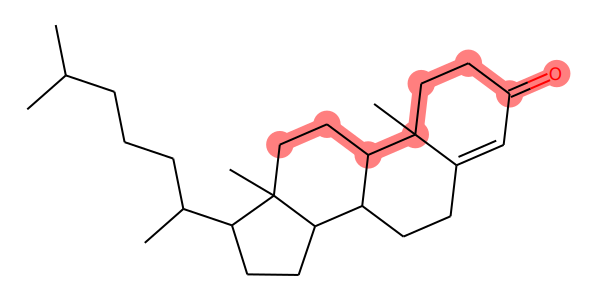

(array([17, 18]),)
109.0709 0.243084053366


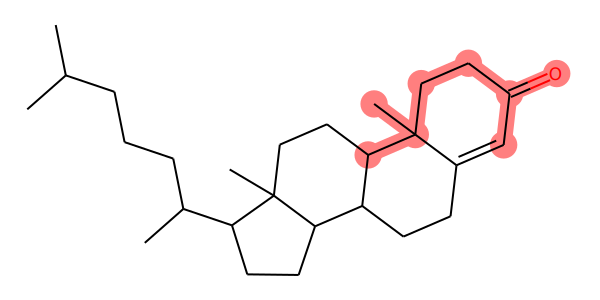

(array([17, 18]),)
109.0709 0.243084053366


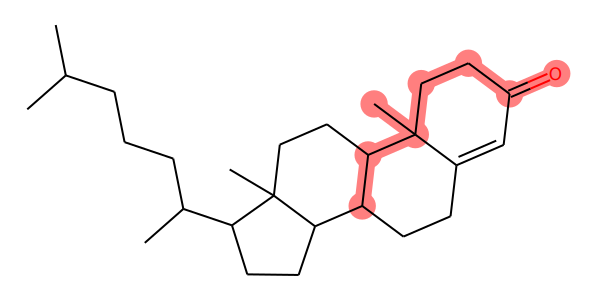

(array([17, 18]),)
109.0709 0.243084053366


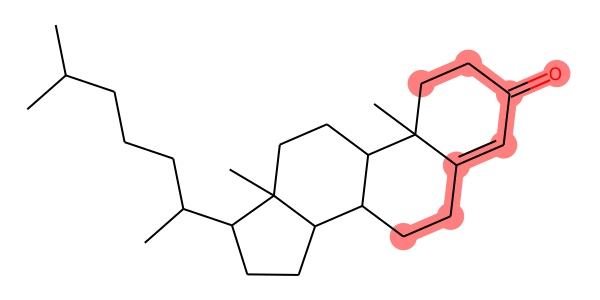

(array([17, 18]),)
109.0709 0.243084053366


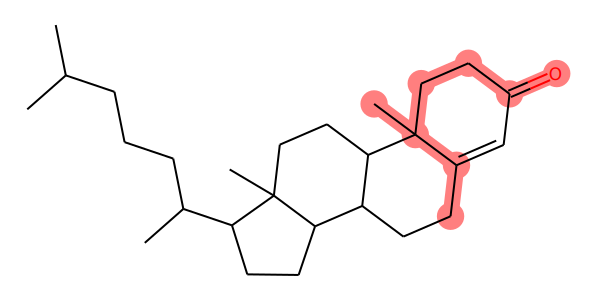

(array([17, 18]),)
109.0709 0.243084053366


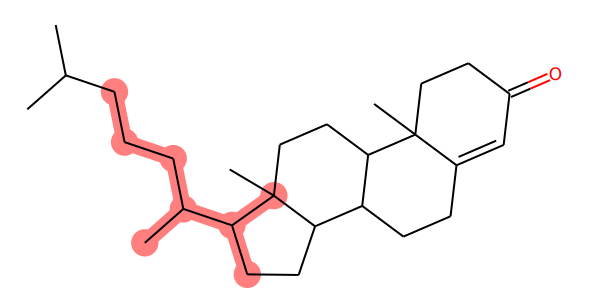

(array([17, 18]),)
109.0709 0.243084053366


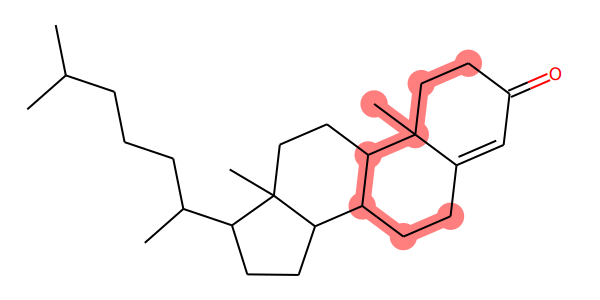

(array([17, 18]),)
109.0709 0.243084053366


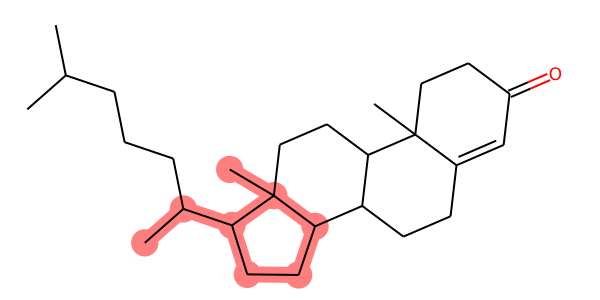

(array([17, 18]),)
109.0709 0.243084053366


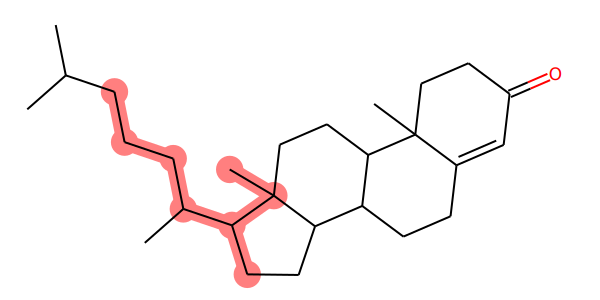

(array([17, 18]),)
109.0709 0.243084053366


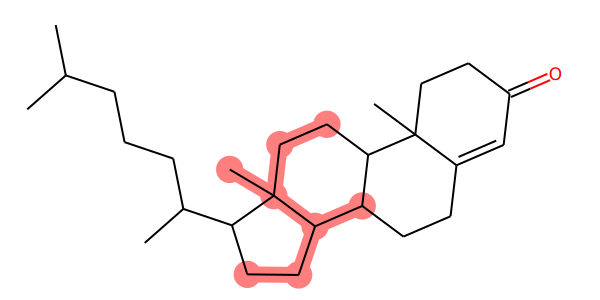

(array([17, 18]),)
109.0709 0.243084053366


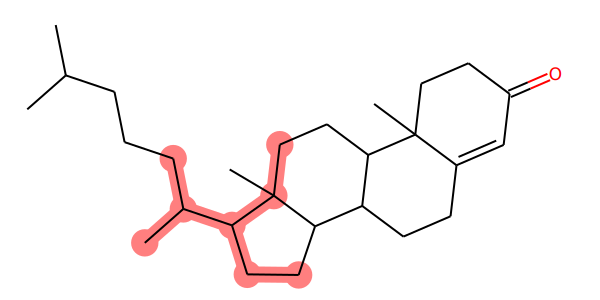

(array([17, 18]),)
109.0709 0.243084053366


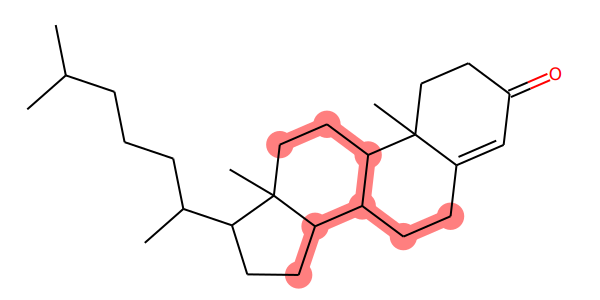

(array([17, 18]),)
109.0709 0.243084053366


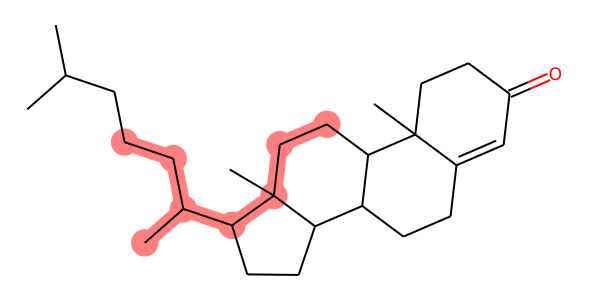

(array([17, 18]),)
109.0709 0.243084053366


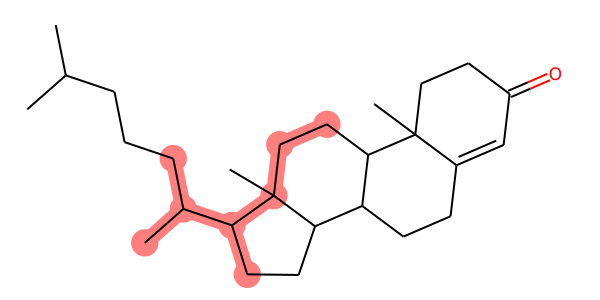

(array([17, 18]),)
109.0709 0.243084053366


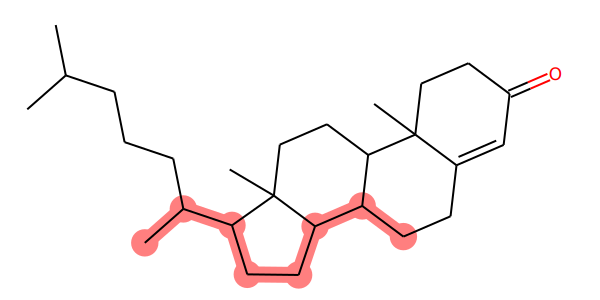

(array([17, 18]),)
109.0709 0.243084053366


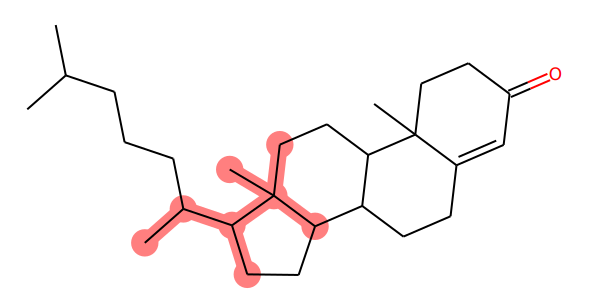

(array([17, 18]),)
109.0709 0.243084053366


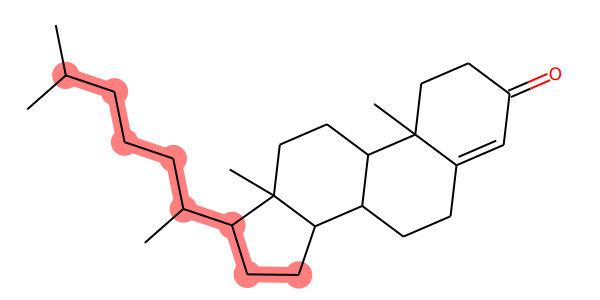

(array([17, 18]),)
109.0709 0.243084053366


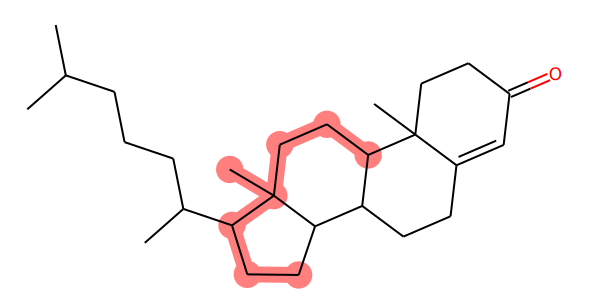

(array([17, 18]),)
109.0709 0.243084053366


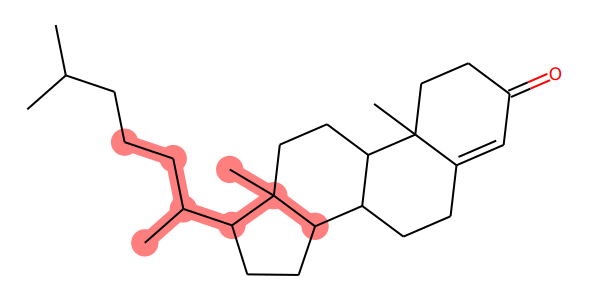

(array([17, 18]),)
109.0709 0.243084053366


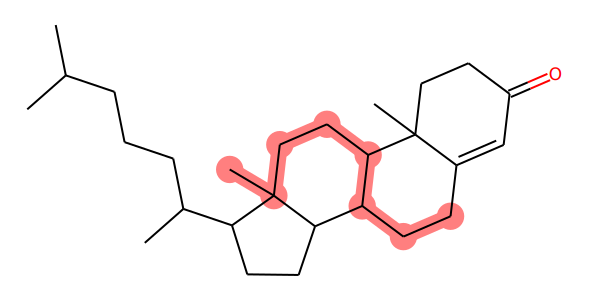

(array([17, 18]),)
109.0709 0.243084053366


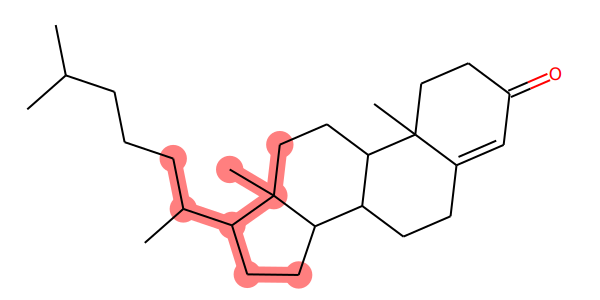

(array([17, 18]),)
109.0709 0.243084053366


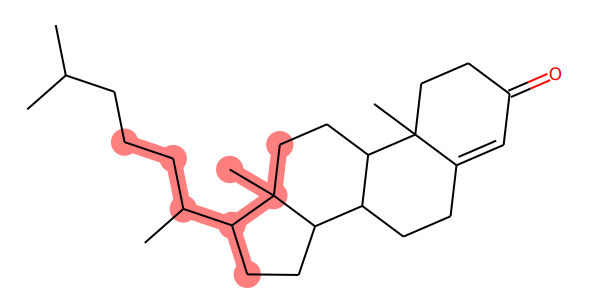

(array([17, 18]),)
109.0709 0.243084053366


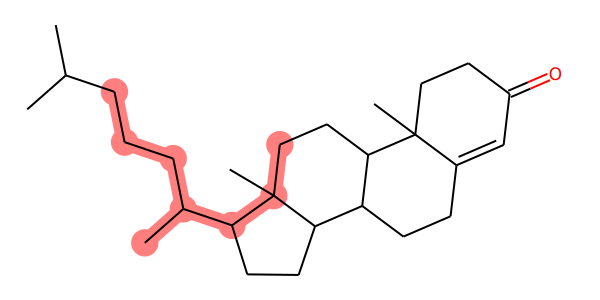

(array([17, 18]),)
109.0709 0.243084053366


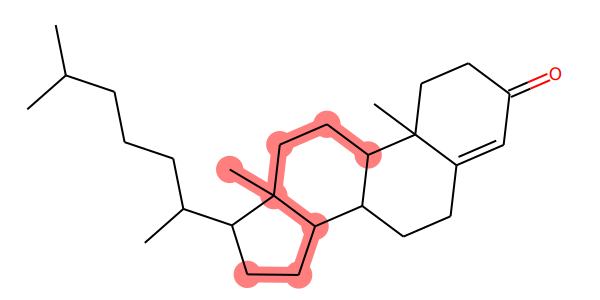

(array([17, 18]),)
109.0709 0.243084053366


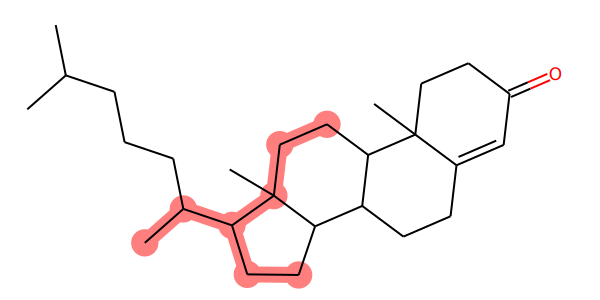

(array([17, 18]),)
109.0709 0.243084053366


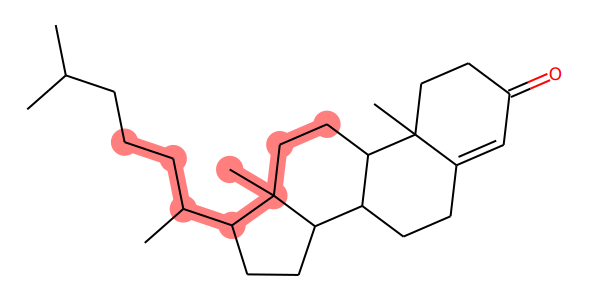

(array([17, 18]),)
109.0709 0.243084053366


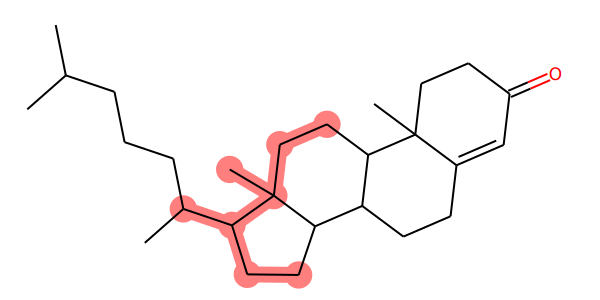

(array([17, 18]),)
109.0709 0.243084053366


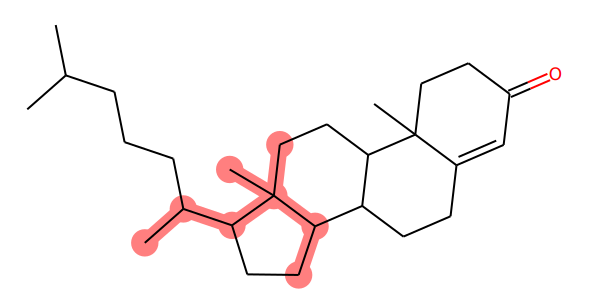

(array([17, 18]),)
109.0709 0.243084053366


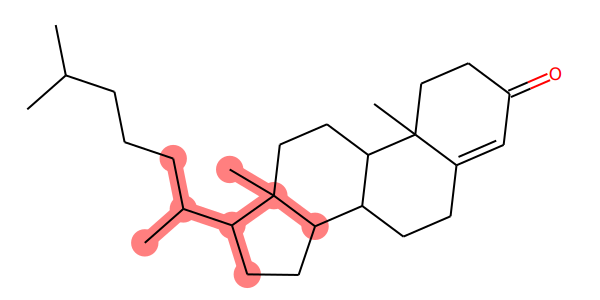

(array([17, 18]),)
109.0709 0.243084053366


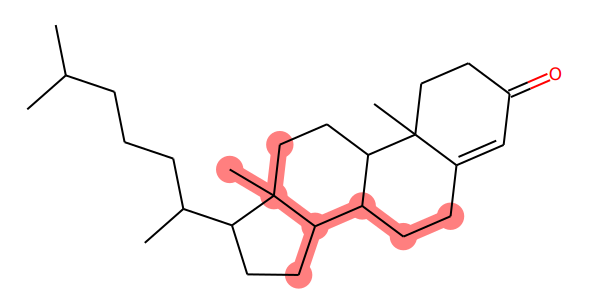

(array([17, 18]),)
109.0709 0.243084053366


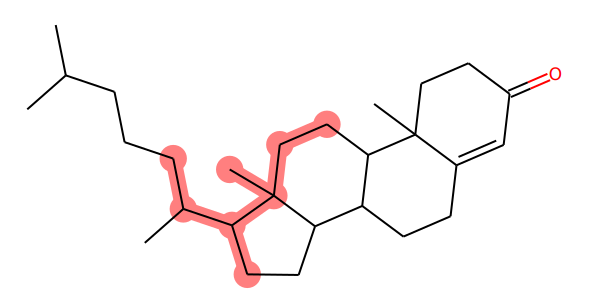

(array([17, 18]),)
109.0709 0.243084053366


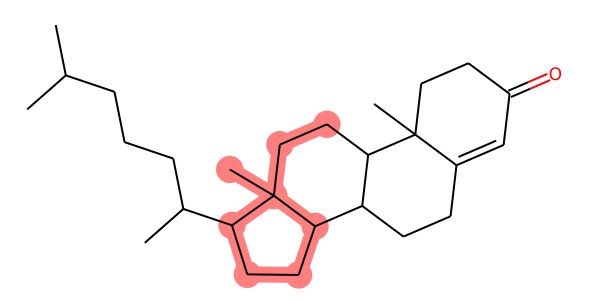

(array([17, 18]),)
109.0709 0.243084053366


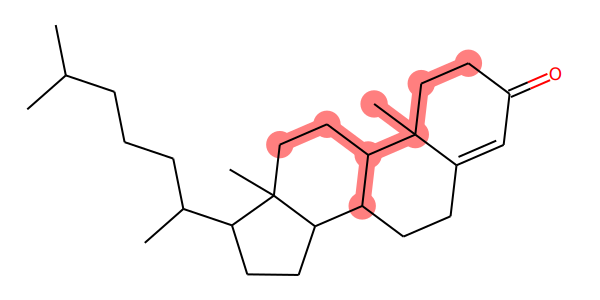

(array([17, 18]),)
109.0709 0.243084053366


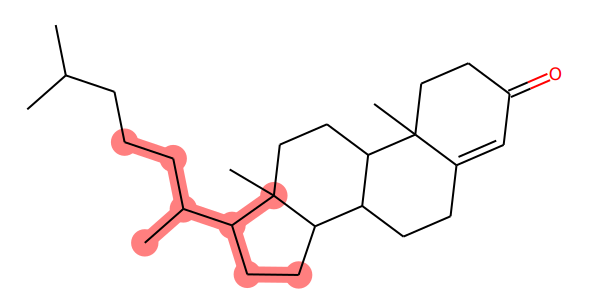

(array([17, 18]),)
109.0709 0.243084053366


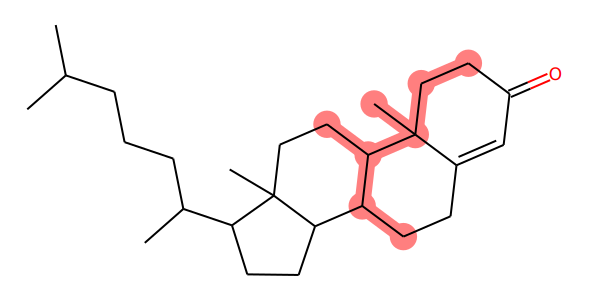

(array([17, 18]),)
109.0709 0.243084053366


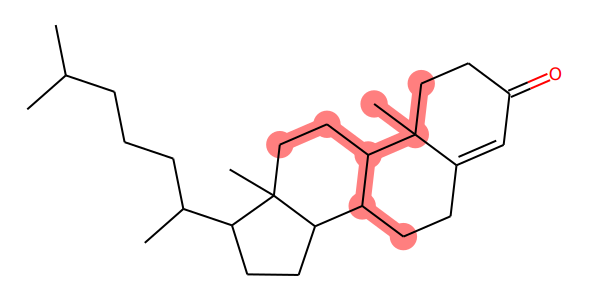

(array([17, 18]),)
109.0709 0.243084053366


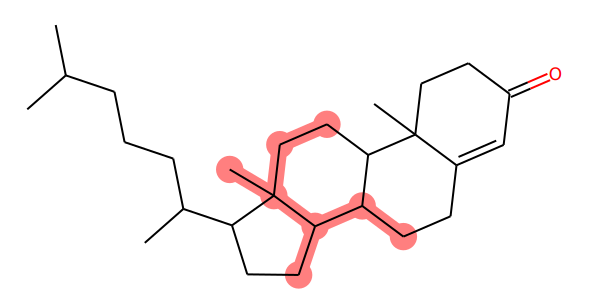

(array([17, 18]),)
109.0709 0.243084053366


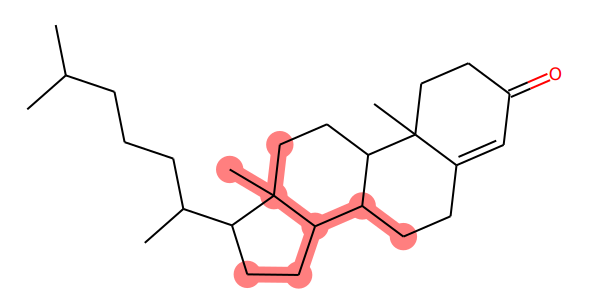

(array([17, 18]),)
109.0709 0.243084053366


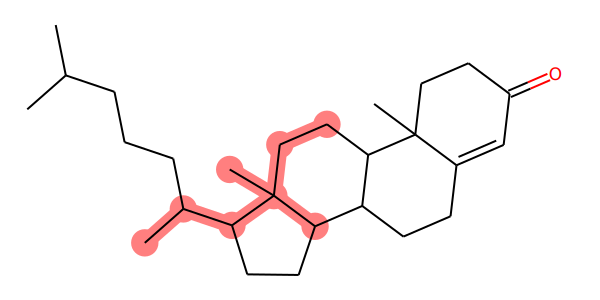

(array([17, 18]),)
109.0709 0.243084053366


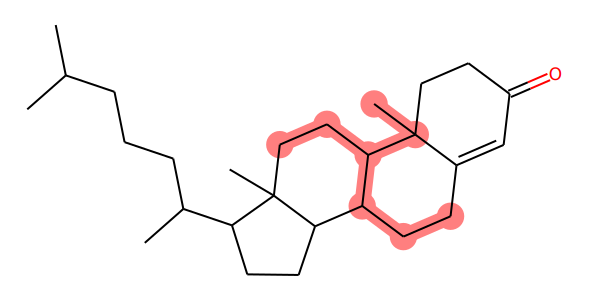

(array([17, 18]),)
109.0709 0.243084053366


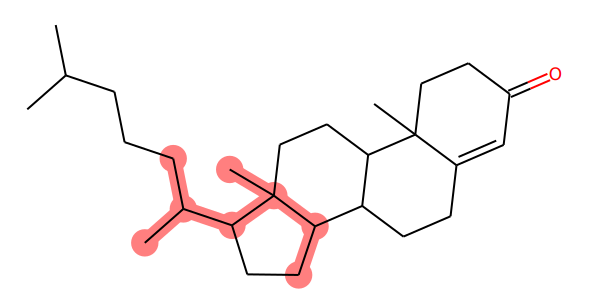

(array([17, 18]),)
109.0709 0.243084053366


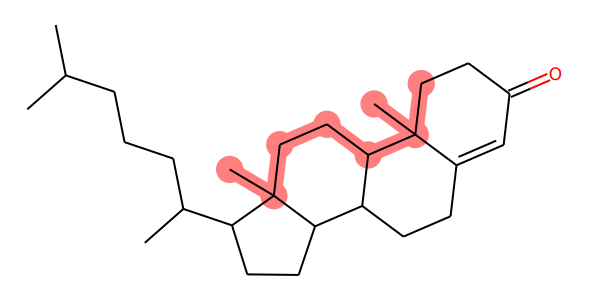

(array([17, 18]),)
109.0709 0.243084053366


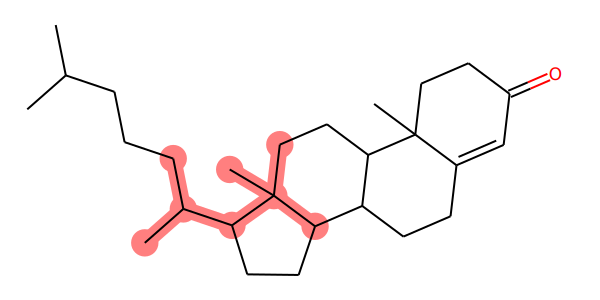

(array([17, 18]),)
109.0709 0.243084053366


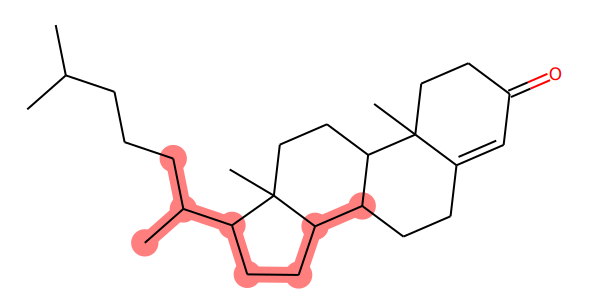

(array([17, 18]),)
109.0709 0.243084053366


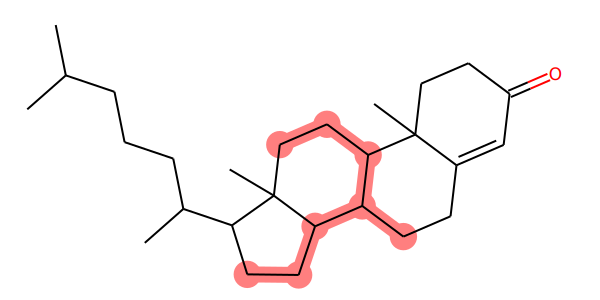

(array([17, 18]),)
109.0709 0.243084053366


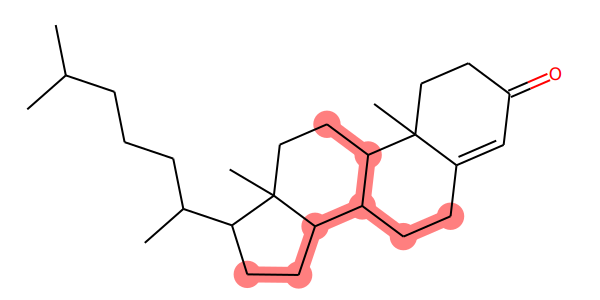

(array([17, 18]),)
109.0709 0.243084053366


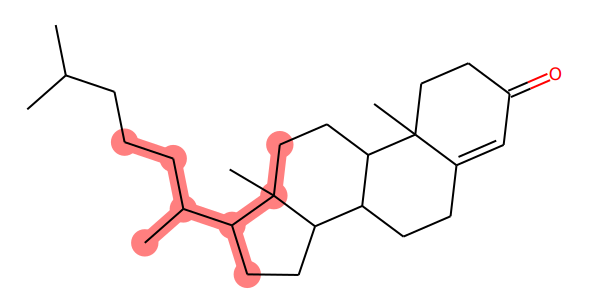

(array([17, 18]),)
109.0709 0.243084053366


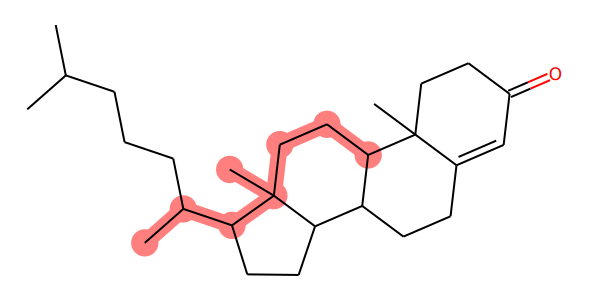

(array([17, 18]),)
109.0709 0.243084053366


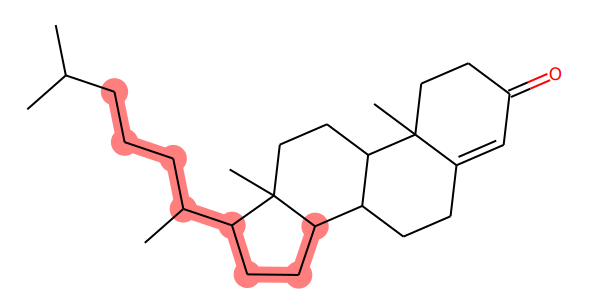

(array([17, 18]),)
109.0709 0.243084053366


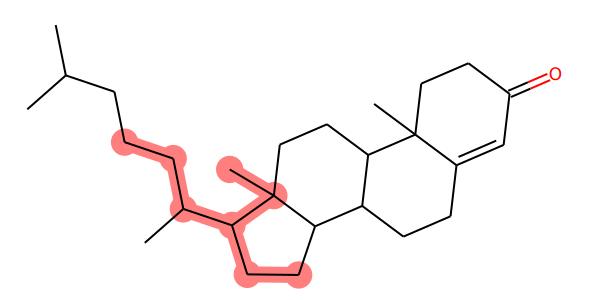

(array([17, 18]),)
109.0709 0.243084053366


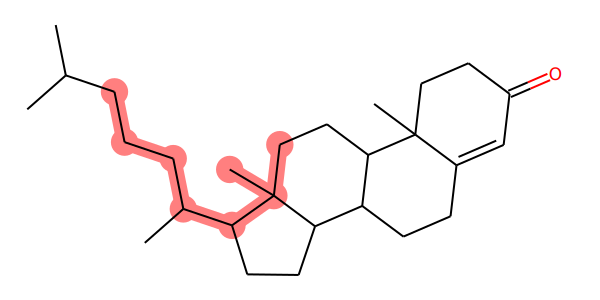

(array([17, 18]),)
109.0709 0.243084053366


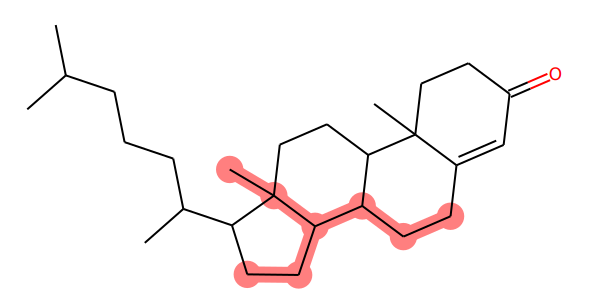

(array([17, 18]),)
109.0709 0.243084053366


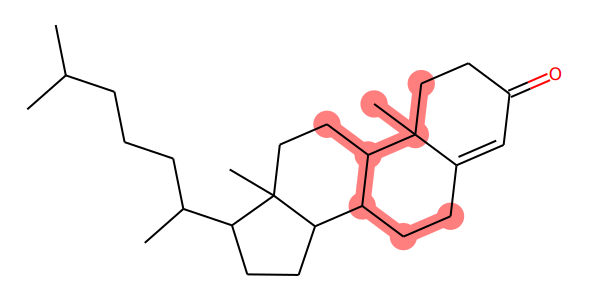

(array([17, 18]),)
109.0709 0.243084053366


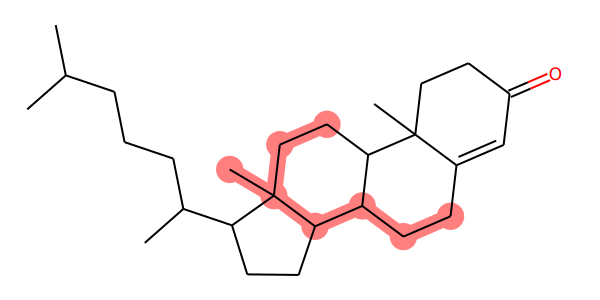

(array([82]),)
385.387756 0.121848865498


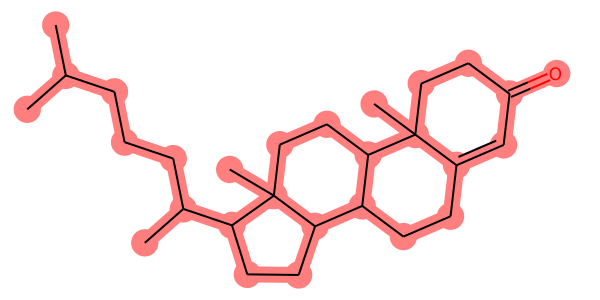

In [77]:
for f in fragment_hits:
    match_ion,hit_indices = get_ion_from_fragment(rMM[f[0],:,:],arr[pactolus_hit_index])
    for m in match_ion:
        if m[1]>0.1:
            print hit_indices
            print m[0],m[1]
            svg= drawStructure_ShowingFragment(pactolus_tree,f[0],myMol,myMol_w_Hs)
            display(SVG(svg))


In [75]:
hit_indices

(array([1]),)

In [495]:
# print pactolus_hits[pactolus_hit_index][pactolus_hits[pactolus_hit_index]>0]

# print pactolus_match_matrix.shape #is [trees by len(neutralizations) * (ions in scan)]

# print arr[pactolus_hit_index].shape[0] * len(pos_mode_neutralizations)

# print pactolus_tree.shape

# most_intense_ion = np.argmax(arr[pactolus_hit_index][:,1])
# print "max position = ",most_intense_ion
# print arr[pactolus_hit_index][most_intense_ion,:]
# # print pactolus_match_matrix[-1,:]
# print np.multiply(most_intense_ion, [1,2,3])+1
# # print len(pactolus_tree[fragment_idx]['atom_bool_arr'])
# # print len(pactolus_tree[fragment_idx]['bond_bool_arr'])
# print pactolus_match_matrix[fragment_idx,np.multiply(most_intense_ion, [1,2,3])+1]

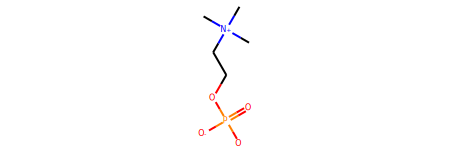

depth is 1


In [529]:
# 0 is atom_bool_arral
fragment_idx = 737
svg,depth = drawStructure_Fragment(pactolus_tree,fragment_idx,myMol,myMol_w_Hs)
display(SVG(svg))
print "depth is",depth



In [26]:
#get ion from fragment




[[ 184.083572      0.90904194]]


In [32]:
s = score_frag_dag.make_pactolus_hit_table(foo,
                                           maxdepth_5_table,
                                           '/global/homes/b/bpb/notebooks/meta-iq_old/midas_lbl/MetaCyc.mdb')

In [52]:
for i in range(10):
    print "real = ", names[i], mz[i]
    print "hit = "
    for h in s[i]:
        print h[0],h[2]

real =  1,2-Dierucoyl-sn-glycero-3-phosphocholine M+H 522.355415634
hit = 
0.0686007 1-18:1-lysophosphatidylcholine
0.00619222 Tween 20
0.000204585 digitoxigenin 3-O-&beta;-D-quinovoside
0.000204585 digiproside
real =  1-Oleoyl-sn-glycero-3-phosphocholine M+H 522.355415634
hit = 
0.071525 1-18:1-lysophosphatidylcholine
0.00630304 Tween 20
0.000693142 digitoxigenin 3-O-&beta;-D-quinovoside
0.000693142 digiproside
real =  1-Palmitoyl-sn-glycero-3-phosphocholine M+H 496.33976557
hit = 
0.265229 (<i>22R,23R</i>)-28-homobrassinolide
0.0730148 1-16:0-lysophosphatidylcholine
0.0467872 2-docosanoyl-LPA
0.0041513 26-hydroxybrassinolide
0.00135356 JI-20B
real =  "1,2-Dierucoyl-sn-glycero-3-phosphocholine" M+H 898.72593179
hit = 
real =  "1,2-Dioleoyl-rac-glycerol" M+NH4 621.545251404
hit = 
0.0605956 diolein
0.0301444 N-(2-hydroxyhenicosanoyl)-4,8-sphingadienine
real =  4-Aminobenzoic acid M+H 138.054954464
hit = 
0.742703 4-fluorothreonine
0.739849 6-aminonicotinamide
0.722887 4-hydroxyacetophe

In [34]:
"""
Create a list of dictionaries.  Each item in the list will be a dict containin the metacyc information.
"""
datafile = 'Selected_rows_from_All_instances_of_Compounds_in_MetaCyc.txt'
with open(datafile, 'rUb') as f:
    metacyc_compounds = list(csv.DictReader(f, dialect='excel-tab'))
print metacyc_compounds[0].keys()

['KEGG', 'Compounds', 'Monoisotopic-Molecular-Weight', 'Wikipedia', 'PubChem', 'Names', 'Common-Name', 'InChI', 'Object ID', 'LIPID MAPS']


In [40]:
metacyc_compounds[10]['Names']

'cystamine'

In [ ]:
metacyc_names = []
metacyc_inchi = []
for myCompound in metacyc_compounds:
    myMol = Chem.MolFromInchi(myCompound['InChI'])
    try:
        myCharge = Chem.GetFormalCharge(myMol)
        if  myCharge != 0:
            (myMol, neutralised) = NeutraliseCharges(myMol)
#             if neutralised == False:
#                 print neutralised, myCompound['Common-Name']
#                 print rdMolDescriptors.CalcMolFormula(neutral_mol)
        c = metob.Compound()
        c.InChI = myCompound['InChI']
        c.formula = rdMolDescriptors.CalcMolFormula(myMol)
        c.MonoIsotopic_molecular_weight = Descriptors.ExactMolWt(myMol)
        c.description = ''
        c.name = myCompound['Common-Name']
        c.store()
                
    except:
        print "Can not parse ", myCompound['Common-Name']